#### This jupyter notebook contains the photorespiration model of the master thesis (by Eldin Imeri)
#### "A mathematical model of the photorespiratory influence on carbon fixation"
#### based on the model of Matuszynska et al (2019) and Zhu et al (2007).

In [1]:
from modelbase.ode import Model, Simulator
import seaborn as sns; sns.set()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import copy
import pandas as pd
from pandas import DataFrame

Could not find GLIMDA.


In [2]:
variables = [
        #"B",  #photosystem II protein concentration
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC",#,  # non-phosphorylated antenna
        "Psbs", # PsBs
        "Vx",  #vioolaxathin relative concentration
        "PGA", # 3-phosphoglycerate
        'BPGA', #
        'GAP', # glyceraldehyde 3-phosphate
        'DHAP', # dihydroxyacetone phosphate
        'FBP', # fructose-1,6-bisphosphate
        'F6P', # fructose-6-phosphate
        'G6P', # 
        'G1P', # 
        'SBP', # sedoheptulose-1,7-bisphosphate
        'S7P', # sedoheptulose-7-phosphate
        'E4P', # erythrose-4-phosphate
        'X5P', # xylulose-5-phosphate
        'R5P', # ribose-5-phosphate
        'RUBP', # ribulose-1,5-isphosphate
        'RU5P', # ribulose-5-phosphate
        "Starch",
        'PGCO', #phosphoglycolat
        'GCO', #glycolat
        'GOX', #glyoxylat
        'Gly', #glycin
        'Ser', #serin
        'HPY', #hydroxypyruvat
        'GCA', #glycerat 
]

define parameters

In [3]:
p = {"convf":3.2*10e-3, #converts ATP and NADPH
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    "kdeg": 100,    # rate of PSII damage corresponds to p.k2 / .5e8
    "krep": 5.55e-4, # rate of repair fo PSII

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core
    "prob_attach": 1.,            # probability of antena attaching to PSI


     # ATP and NADPH parameters
    "kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    "kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

     #"O2ext": 8., # corresponds to 250 microM or to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
     
        # gas exchange air -> cytosol
     # cellular concentrations for CO2 and O2
     # (~13µM / ~270µM respectively under standard conditions)
     'CO2': (0.00038*        # CO2 percentage of air
             56000*          # molar conc. water [mM]
             1)/             # athmospheric pressure [atm]
            (1.6*(10**3)),   # Henry constant of CO2
     'O2':  (0.21*           # O2 percentage of air
             56000*          # molar conc. water [mM]
             1)/             # athmospheric pressure [atm]
            (4.3*(10**4)),   # Henry constant of O2
     
     # CBB cycle associated parameter set according to Pettersson and Pettersson 1988
    'CN': 0.5,
    #'CO2': 0.2,# saturated 
    'Cp': 15+2.05,#15.0
    'Ca': 0.5,
    'pHmedium': 7.6,
    'pHstroma': 7.9,
    'Pext': 0.5,

    #Vmaxes of Calvin cycle enzymes
    'V1': 0.34*8,
    'V6': 0.2*8,
    'V9': 0.04*8,
    'V13': 0.9999*8,
    'Vst': 0.04*8,
    'Vx': 0.25*8,

    #equilibrium constants of calvin cycle enzymes
    'q2': 3.1 * (10.0 ** (-4.0)),
    'q3': 1.6 * (10.0**7.0),
    'q4': 22.0,
    'q5': (7.1),
    'q7': 0.084,
    'q8': (13.0),
    'q10': 0.85,
    'q11': 0.4,
    'q12': 0.67,
    'q14': 2.3,
    'q15': 0.058,

    #michaelis constants of calvin cycle enzymes
    'Km1': 0.02,
    #'KmCO2': 0.0107, #Km from Zhu's model is used
    'Km6': 0.03,
    'Km9': 0.013,
    'Km131': 0.05,
    'Km132': 0.05,
    'Km161': 0.014,
    'Km162': 0.3,
    'Kmst1': 0.08,
    'Kmst2': 0.08,
    'Kmnadph': 0.19, #ausgerechneter wert (ideal wert)
    'Kpga': 0.25,
    'Kgap': 0.075,
    'Kdhap': 0.077,
    'Kpi': 0.63,
    'Kpxt': 0.74,
    'Ki11': 0.04,
    'Ki12': 0.04,
    'Ki13': 0.075,
    'Ki14': 0.9,
    'Ki15': 0.07,
    'Ki61': 0.7,
    'Ki62': 12.0,
    'Ki9': 12.0,
    'Ki131': 2.0,
    'Ki132': 0.7,
    'Ki133': 4.0,
    'Ki134': 2.5,
    'Ki135': 0.4,
    'Kist': 10.0,
    'Kast1': 0.1,
    'Kast2': 0.02,
    'Kast3': 0.02,

    'k': 10.0**8.0*8,
    'oxPPP': 0.,
     
      # RuBisCO (from Zhu 2007)
    'Ef':1.456965457,
    'vcmax': 2.913930914*8,
    'vomax': 2.913930914*0.24*8,
    'KmCO2':0.0115,
    'KmO2':0.222,
     
      ### Respiration (from Zhu 2007)

    # VR1: PGCO phosphatase
    'km1r1': 0.026, # Km PGCO
    'v1r': 52.4199*8,
    'ki1r1': 94, # Ki GCO
    'ki1r2': 2.55, # Ki Pi
    # VR2: GCO oxidase
    'v2r': 1.45611*8 ,
    'km2r1': 0.1, # Km GCO
    # VR3: Glu:GOX aminotransferase
    'v3r': 2.74582*8 ,
    'km3r1': 0.15, #Km GOX
    'ki3r1': 2, # Ki Glycin
    # VR4: Gly decarboxylase
    'v4r': 2.49475*8 ,
    'km4r1': 6 , # Km Glycin
    'ki4r1': 4, # Ki Serin
    # VR5: Ser:GOX aminotransferase
    'v5r': 3.30619 , 
    'q5r': 0.24 , 
    'km5r1': 2.7 , # Km Serin
    'ki5r1': 33 , # Ki Glycin
    'km5r2': 0.15, # Km Glyoxylat
    # VR6: GCA dehydrogenase
    'v6r': 10.0098 , 
    'q6r': 250000 , 
    'km6r1': 0.09 , # Km HPyr
    'ki6r1': 12, # Ki HPyr
    # VR7: GCA kinase
    'v7r': 5.71579, 
    'q7r': 300 , 
    'km7r1': 0.21, # Km ATP
    'ki7r1': 0.36, # Ki PGA
    'km7r2': 0.25, # Km Glycerat 
    
     # starch degrade, oxPPP enzyme parameters, taken from Messiha et al 2014
     # parameters from enzyme SOL chosen (lowest vmax, highest Km, highest flux control)
    'vstx': 0.296,
    'kmstx1': 0.8,
 
}

In [4]:
m = Model(parameters=p, compounds=variables)

In [5]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

# FIX ME: we used two different definitions for H_stroma (!). This one is Nima's
m.add_derived_parameter(
    parameter_name="H_stroma", function=lambda pHstroma: (10.0**((-1.0)*pHstroma))*1000.0, parameters=["pHstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [6]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [7]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def xmoiety(Vx, Xtot):
    return Xtot - Vx

m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs) #/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)
    

def ps2states(PQ, PQred, ps2cs, Q, PSIItot, k2, kF, _kH, Keq_PQred, kPQred, pfd, kH0):
    L = ps2cs * light(pfd)
    kH = kH0 + _kH * Q
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs", "Q"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "Keq_PQred", "kPQred", "pfd", "kH0"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(Q, B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + k2 + kH*Q) + (ps2cs * kF * B2) / (kF + kH*Q)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["Q", "B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

def Pimoiety(PGA,PGCO,BPGA,GAP,DHAP,FBP,F6P,G6P,G1P,SBP,S7P,E4P,X5P,R5P,RUBP,RU5P,ATP, Cp):
    return Cp - (PGA+PGCO+2*BPGA+GAP+DHAP+2*FBP+F6P+G6P+G1P+2*SBP+S7P+E4P+X5P+R5P+2*RUBP+RU5P+ATP)

m.add_algebraic_module(
    module_name="pi_alm",
    function=Pimoiety,
    compounds=["PGA","PGCO","BPGA","GAP","DHAP","FBP","F6P","G6P","G1P","SBP","S7P","E4P","X5P","R5P","RUBP","RU5P","ATP"],
    derived_compounds=["Pi"],
    parameters=["Cp"],
    modifiers=None
)

def Nmoiety(Pi, PGA, GAP, DHAP, Kpxt, Pext, Kpi, Kpga, Kgap, Kdhap):
    """Used several times to calculate the rate of vPGA, vGAP and vDHAP"""
    return 1+(1+(Kpxt/Pext))*((Pi/Kpi)
               +(PGA/Kpga)
               +(GAP/Kgap)
               +(DHAP/Kdhap))

m.add_algebraic_module(
    module_name="n_alm",
    function=Nmoiety,
    compounds=["Pi","PGA","GAP","DHAP"],
    derived_compounds=["N"],
    parameters=["Kpxt", "Pext", "Kpi", "Kpga", "Kgap", "Kdhap"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [8]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)


In [9]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, O2, kNDH, Ton, Toff, convf):
    """ return oxygen and NDH concentration as a function of time"""
    Ox2 = (O2+0.01)/convf
    if Ox2 > 0:
        return Ox2, kNDH
    else:
        if time<Ton or time>Toff:
            return Ox2, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, O2, kNDH, Ton, Toff, convf):
    """ return oxygen and NDH concentration as a function of time"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, O2, kNDH, Ton, Toff, convf))
    else:
        return np.array(
            [
                _oxygen(t, O2, kNDH, Ton, Toff, convf)
                for t in time
            ]
        ).T     
        
def vPTOX(PQred, time, kPTOX, O2, kNDH, Ton, Toff, convf):
    """ calculates reaction rate of PTOX """
    v = PQred * kPTOX * (oxygen(time, O2, kNDH, Ton, Toff, convf)[0])
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "O2", "kNDH", "Ton", "Toff", "convf"],
    reversible=False,
)


def vNDH(PQ, time, O2, kNDH, Ton, Toff, convf):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, O2, kNDH, Ton, Toff, convf)[1] * PQ
    return v

m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["O2", "kNDH", "Ton", "Toff", "convf"],
    reversible=False,
)


def vB6f(PC, PQ, H, PQred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (PQred * PC**2 - (PQ * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(PQ, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * PQ)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR, convf):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH/convf)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP/convf)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1*m.get_parameter('convf')},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR", "convf"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT, convf):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP/convf - ATP/convf / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1*m.get_parameter('convf'), "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT","convf"],
    reversible=True,
)


def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)

In [10]:
""" Calvin-Benson-Bassham Cycle Reaction Rates """
def v1c(RUBP, PGA, FBP, SBP, Pi, NADPH, vcmax, CO2, KmCO2, O2, KmO2, Ef, Km1, Ki11, Ki12, Ki13, Ki14, Ki15):
    """ rate of RuBisCO carboxylation
    3 Ribulose-1,5-bisphosphate + 3 CO2
    -- RuBisCO -->
    6 3-Phosphoglycerate
    RuBp + CO2 -> PGA
    """
    Wc_min = (vcmax*CO2/(CO2+KmCO2*(1+O2/KmO2)))*((1+RUBP/Ef)-abs(1-RUBP/Ef))/2  
    vc = Wc_min*RUBP/((RUBP+Km1*(1+(PGA/Ki11)+(FBP/Ki12)+(SBP/Ki13)+(Pi/Ki14)+((NADPH)/Ki15))))
    return vc

m.add_reaction(
    rate_name='vRuBisCOc',
    function=v1c,
    stoichiometry= {"RUBP": -1, "PGA": 2},
    dynamic_variables=["RUBP", "PGA", "FBP", "SBP", "Pi", "NADPH"],
    parameters=["vcmax", "CO2", "KmCO2", "O2", "KmO2", "Ef","Km1", "Ki11", "Ki12", "Ki13", "Ki14", "Ki15"],
    reversible=True,
)

def v1o(RUBP, PGA, FBP, SBP, Pi, NADPH, vomax, O2, KmO2, CO2, KmCO2, Ef, Km1, Ki11, Ki12, Ki13, Ki14, Ki15):
    """ rate of RuBisCO oxygenation
        Ribulose-1,5-bisphosphate + O2
        -- RuBisCO -->
        3-Phosphoglycerate + 2-Phosphoglycolate
        RuBp + O2 -> PGA + PGCO
    """
    Wo_min = (vomax*O2/(O2+KmO2*(1+CO2/KmCO2)))*((1+RUBP/Ef)-abs(1-RUBP/Ef))/2  
    vo = Wo_min*RUBP/((RUBP+Km1*(1+(PGA/Ki11)+(FBP/Ki12)+(SBP/Ki13)+(Pi/Ki14)+((NADPH)/Ki15))))
    return vo

m.add_reaction(
    rate_name='vRuBisCOo',
    function=v1o,
    stoichiometry= {"RUBP": -1, "PGA": 1, "PGCO": 1},
    dynamic_variables=["RUBP", "PGA", "FBP", "SBP", "Pi", "NADPH"],
    parameters=["vomax", "O2", "KmO2", "CO2", "KmCO2", "Ef","Km1", "Ki11", "Ki12", "Ki13", "Ki14", "Ki15"],
    reversible=True,
)

def v2(ATP, PGA, BPGA, ADP, k, q2):
    """
    6 3-Phosphoglycerate + 6 ATP
    -- Phosphoglycerate kinase (PGK) -->
    6 1,3-Bisphosphoglycerate + 6 ADP
    PGA + ATP -> BPGA + ADP
    Assumed to be at equilibrium
    """
    return k*((ATP*PGA)-(1/q2)*(ADP*BPGA))

m.add_reaction(
    rate_name='vPGA_kinase',
    function=v2,
    stoichiometry= {"ATP": -1, "PGA": -1, "BPGA": 1},
    modifiers=["ADP"],
    parameters=["k", "q2"],
    reversible=True,
)

def v3(BPGA, NADPH, GAP, NADP, Pi, k, H_stroma, q3):
    """
    6 1,3-Bisphosphoglycerate + 6 NADPH + 6 H+
    -- Glyceraldehyde 3-phosphate dehydrogenase (GADPH)-->
    1 G3P + 5 Glyceraldehyde 3-phosphate
    BPGA + NADPH -> GAP + NADP
    Assumed to be at equilibrium
    Stroma pH is assumed to be constant
    """

    return k*((NADPH*BPGA*H_stroma)-(1/q3)*(GAP*NADP*Pi))

m.add_reaction(
    rate_name='vBPGA_dehydrogenase',
    function=v3,
    stoichiometry= {"BPGA": -1, "NADPH": -1, "GAP": 1},
    dynamic_variables=["BPGA", "NADPH", "GAP", "NADP", "Pi"],
    parameters=["k", "H_stroma", "q3"],
    reversible=True,
)

def v4(GAP, DHAP, k, q4):
    """ 
    (5) Glyceraldehyde 3-phosphate
    -- Triose phosphate isomerae (TPI)-->
    (?) Dihydroxyacetone phosphate
    GAP -> DHAP
    Assumed to be at equilibrium
    """
    return k*((GAP)-(1/q4)*(DHAP))

m.add_reaction(
    rate_name='vTPI',
    function=v4,
    stoichiometry= {"GAP": -1, "DHAP": 1},
    parameters=["k", "q4"],
    reversible=True,
)

def v5(GAP, DHAP, FBP, k, q5):
    """
    (5) Glyceraldehyde 3-phosphate + (?) Dihydroxyacetone phosphate
    -- Aldolase (ALD)-->
    Frucose 1,6-bisphosphate
    GAP + DHAP -> FBP
    Assumed to be at equilibrium
    """
    return k*((GAP*DHAP)-(1/q5)*(FBP))

m.add_reaction(
    rate_name='vAldolase',
    function=v5,
    stoichiometry= {"GAP": -1, "DHAP": -1, "FBP": 1},
    parameters=["k", "q5"],
    reversible=True,
)

def v6(FBP, F6P, Pi, V6, Km6, Ki61, Ki62):
    """
    (?) Fructose 1,6-bisphosphate + (?) H20
    --Fructose 1,6-bisphosphatase (FBPase) -->
    (6) Fructose 6-phosphate + (Pi)
    FBP -> F6P
    """
    return (V6*FBP)/(FBP+Km6*(1+(F6P/Ki61)+(Pi/Ki62)))

m.add_reaction(
    rate_name='vFBPase',
    function=v6,
    stoichiometry= {"FBP": -1, "F6P": 1},
    modifiers= ["Pi"],
    parameters=["V6", "Km6", "Ki61", "Ki62"],
    reversible=True,
)

def v7(GAP, F6P, X5P, E4P, k, q7):
    """
    (?) Fructose 6-phosphate + (?) Glyceraldehyde 3-phosphate
    -- Transketolase (TK) -->
    (?) Xylulose 5-phosphate + (?) Erythrose 4-phosphate
    GAP + F6P -> X5P + E4P
    Assumed to be at equilibrium
    """
    return k*((GAP*F6P)-(1/q7)*(X5P*E4P))

m.add_reaction(
    rate_name='vF6P_Transketolase',
    function=v7,
    stoichiometry= {"GAP": -1, "F6P": -1, "X5P": 1, "E4P": 1},
    parameters=["k", "q7"],
    reversible=True,
)

def v8(DHAP, E4P, SBP, k, q8):
    """
    (?) Dihydroxyacetone phosphate + (?) Erythrose 4-phosphate
    -- Aldolase (ALD)-->
    (?) Sedoheptulose 1,7-bisphosphate
    DHAP + E4P -> SBP
    Assumed to be at equilibrium
    """
    return k*((DHAP*E4P)-(1/q8)*(SBP))

m.add_reaction(
    rate_name='v8',
    function=v8,
    stoichiometry= {"DHAP": -1, "E4P": -1, "SBP": 1},
    parameters=["k", "q8"],
    reversible=True,
)

def v9(SBP, Pi, V9, Km9, Ki9):
    """
    (?) Sedoheptulose 1,7-bisphosphate + H20
    --Sedoheptulose 1,7-bisphosphatase (SBPase)-->
    (?) Sedoheptulose 7-phosphate + (?) Pi
    SBP -> S7P
    """

    return (V9*SBP)/(SBP+Km9*(1+(Pi/Ki9)))

m.add_reaction(
    rate_name='v9',
    function=v9,
    stoichiometry= {"SBP": -1, "S7P": 1}, #CHECKME
    dynamic_variables=["SBP","Pi"],
    parameters=["V9", "Km9", "Ki9"],
    reversible=True,
)

def v10(GAP, S7P, X5P, R5P, k, q10):
    return k*((GAP*S7P)-(1/q10)*(X5P*R5P))

m.add_reaction(
    rate_name='v10',
    function=v10,
    stoichiometry= {"GAP": -1, "S7P": -1, "X5P": 1, "R5P": 1}, 
    parameters=["k", "q10"],
    reversible=True,
)

def v11(R5P, RU5P, k, q11):
    return k*((R5P)-(1/q11)*(RU5P))

m.add_reaction(
    rate_name='v11',
    function=v11,
    stoichiometry= {"R5P": -1, "RU5P": 1}, 
    parameters=["k", "q11"],
    reversible=True,
)

def v12(X5P, RU5P, k, q12):
    return k*((X5P)-(1/q12)*(RU5P))

m.add_reaction(
    rate_name='v12',
    function=v12,
    stoichiometry= {"X5P": -1, "RU5P": 1}, 
    parameters=["k", "q12"],
    reversible=True,
)

def v13(RU5P, ATP, RUBP, PGA, Pi, ADP, V13, Km131, Ki131, Ki132, Ki133, Ki134, Km132, Ki135):
    return (V13*RU5P*ATP)/((RU5P+Km131*(1+(PGA/Ki131)+(RUBP/Ki132)+(Pi/Ki133)))*(ATP*(1+(ADP/Ki134))+Km132*(1+(ADP/Ki135))))

m.add_reaction(
    rate_name='v13',
    function=v13,
    stoichiometry= {"RU5P": -1, "ATP": -1, "RUBP": 1}, 
    modifiers=["PGA", "Pi", "ADP"],
    parameters=["V13", "Km131", "Ki131", "Ki132", "Ki133", "Ki134", "Km132", "Ki135"],
    reversible=True,
)

def v14(F6P, G6P, k, q14, pfd):
    return k*((F6P)-(1/q14)*(G6P)) * (((1+pfd/25)-abs(1-pfd/25))/2)
#added low light restriction to rate to decrease during low light conditions for easier CBB cycle regeneration
m.add_reaction(
    rate_name='vG6P_isomerase',
    function=v14,
    stoichiometry= {"F6P": -1, "G6P": 1}, 
    parameters=["k", "q14", "pfd"],
    reversible=True,
)

def v15(G6P, G1P, k, q15):
    return k*((G6P)-(1/q15)*(G1P))

m.add_reaction(
    rate_name='vPhosphoglucomutase',
    function=v15,
    stoichiometry= {"G6P": -1, "G1P": 1}, 
    parameters=["k", "q15"],
    reversible=True,
)

def vpga(PGA, N, Vx, Kpga):
    return (Vx*PGA)/(N*Kpga)

m.add_reaction(
    rate_name='vpga',
    function=vpga,
    stoichiometry= {"PGA": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kpga"],
    reversible=True,
)

def vgap(GAP, N, Vx, Kgap):
    return (Vx*GAP)/(N*Kgap)

m.add_reaction(
    rate_name='vgap',
    function=vgap,
    stoichiometry= {"GAP": -1}, 
    modifiers=["N"],
    parameters=["Vx", "Kgap"],
    reversible=True,
)

def vdhap(DHAP, N, Vx, Kdhap):
    return (Vx*DHAP)/(N*Kdhap)

m.add_reaction(
    rate_name='vdhap',
    function=vdhap,
    stoichiometry= {"DHAP": -1},
    modifiers=["N"],
    parameters=["Vx", "Kdhap"],
    reversible=True,
)

def vStarch(G1P, ATP, ADP, Pi, PGA, F6P, FBP, Vst, Kmst1, Kist, Kmst2, Kast1, Kast2, Kast3):
    """G1P -> Gn-1 ; Starch production"""
    return (Vst*G1P*ATP)/((G1P+Kmst1)*((1+(ADP/Kist))*(ATP+Kmst2)+((Kmst2*Pi)/(Kast1*PGA+Kast2*F6P+Kast3*FBP))))

m.add_reaction(
    rate_name='vStarch',
    function=vStarch,
    stoichiometry= {"G1P": -1, "ATP": -1, 'Starch':1}, 
    modifiers= ["ADP", "Pi", "PGA", "F6P", "FBP"],
    parameters=["Vst", "Kmst1", "Kist", "Kmst2", "Kast1", "Kast2", "Kast3"],
    reversible=False,
)

def Vstdeg(Starch, RU5P, vstx, kmstx1, pfd):
    """starch degradation to RU5P, during low light, for recovery of CBB cycle"""
    return ((vstx*Starch)/(kmstx1+Starch)) * (((1+(25**2)/(pfd**2))-abs(1-(25**2)/(pfd**2)))/2)

m.add_reaction(
    rate_name='vStdeg',
    function=Vstdeg,
    stoichiometry= {"Starch": -1, "RU5P":1},
    parameters=["vstx", "kmstx1", "pfd"],
    reversible=True,
)

In [11]:
  ''' Photorespiration reaction rates '''
    
def VR1(PGCO, GCO, Pi, v1r, km1r1, ki1r1, ki1r2):
    ''' PGCO phosphatase
    [PGCO] → [GCO]'''
    return ((v1r*PGCO)/(PGCO+km1r1*(1+GCO/ki1r1)*(1+Pi/ki1r2)))

m.add_reaction(
    rate_name='vR1',
    function=VR1,
    stoichiometry= {'PGCO':-1,'GCO':1},
    modifiers=["Pi"],
    parameters=["v1r", "km1r1", "ki1r1", "ki1r2"],
    reversible=True,
)

def VR2(GCO, v2r, km2r1):
    '''  GCO oxidase
    [GCO] → [GOX]'''
    return (v2r*GCO)/(GCO+km2r1)

m.add_reaction(
    rate_name='vR2',
    function=VR2,
    stoichiometry= {'GCO':-1,'GOX':1},
    parameters=["v2r", "km2r1"],
    reversible=False,
)

def VR3(GOX, Gly, v3r, km3r1, ki3r1):
    '''  Glu:GOX aminotransferase
    simplified by omitting glutamate and ketoglutarate
    [Glu] + [GOX] ↔ [a-KG] + [Gly];'''
    return (v3r*GOX)/(GOX+km3r1*(1+Gly/ki3r1))

m.add_reaction(
    rate_name='vR3',
    function=VR3,
    stoichiometry= {'GOX':-1,'Gly':1},
    parameters=["v3r", "km3r1", "ki3r1"],
    reversible=True,
)

def VR4(Gly, Ser, v4r, km4r1, ki4r1):
    ''' Gly decarboxylase
    2.0 × [Gly] → [Ser]'''
    return (v4r*Gly)/(Gly+km4r1*(1+Ser/ki4r1))

m.add_reaction(
    rate_name='vR4',
    function=VR4,
    stoichiometry= {'Gly':-2,'Ser':1},
    parameters=["v4r", "km4r1", "ki4r1"],
    reversible=True,
)

def VR5(Ser, GOX, HPY, Gly, k, q5r, km5r1, ki5r1, km5r2):
    ''' Ser:GOX aminotransferase
    [Ser] + [GOX] ↔ [HPY] + [Gly]'''
    return k*(Ser*GOX-HPY*Gly/q5r)/((Ser+km5r1*(1+Gly/ki5r1))*(GOX+km5r2))

m.add_reaction(
    rate_name='vR5',
    function=VR5,
    stoichiometry= {'GOX':-1,'Ser':-1,'Gly':1,'HPY':1},
    parameters=["k", "q5r", "km5r1", "ki5r1", "km5r2"],
    reversible=True,
)

def VR6(HPY, GCA, k, km6r1, ki6r1, q6r):
    ''' GCA dehydrogenase
    [HPY] + [NADH] ↔ [GCA] + [NAD]'''  
    return k*(HPY-GCA/q6r)/(HPY+km6r1*(1+HPY/ki6r1))

m.add_reaction(
    rate_name='vR6',
    function=VR6,
    stoichiometry= {'HPY':-1,'GCA':1},
    parameters=["k", "km6r1", "ki6r1", "q6r"],
    reversible=True,
)
    
def VR7(ATP, GCA, PGA, ADP, k, q7r, km7r1, ki7r1, km7r2):
    ''' GCA kinase
    [ATP] + [GCA] ↔ [PGA] + [ADP]'''
    return k*((ATP)*GCA-PGA*(ADP)/q7r)/(((ATP)+km7r1*(1+PGA/ki7r1))*(GCA+km7r2))

m.add_reaction(
    rate_name='vR7',
    function=VR7,
    stoichiometry= {'GCA':-1,'PGA':1,'ATP':-1},
    modifiers=["ADP"],
    parameters=["k", "q7r", "km7r1", "ki7r1", "km7r2"],
    reversible=True,
)

In [12]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {
        "PQ":m.get_parameter('PQtot')/2,
        "PC":m.get_parameter('PCtot')/2,
        "Fd":m.get_parameter('Fdtot')/2,
        "ATP":0.12,
        "NADPH":0.281543418344,
        "H":calculate_pHinv(7.2),
        "LHC":0.9,
        "Psbs":0.9,
        "Vx":0.9,
        "PGA":2.15,
        'BPGA':0.000907499521924,
        'GAP':0.011839616887,
        'DHAP':0.260471552645,
        'FBP':0.11,
        'F6P':0.36,
        'G6P':0.46,
        'G1P':0.166166918189,
        'SBP':0.2,
        'S7P':0.56,
        'E4P':0.0330766864679,
        'X5P':0.0374527459593,
        'R5P':0.0627333486958,
        'RUBP':0.45,
        'RU5P':0.02,
        'Starch':0.5,
        'PGCO':0.0029,
        'GCO':0.36, 
        'GOX':0.028, 
        'Gly':1.8,  # 0.6 
        'Ser':7.5,  # 4.3 
        'HPY':0.1035, 
        'GCA':0.1812,
}

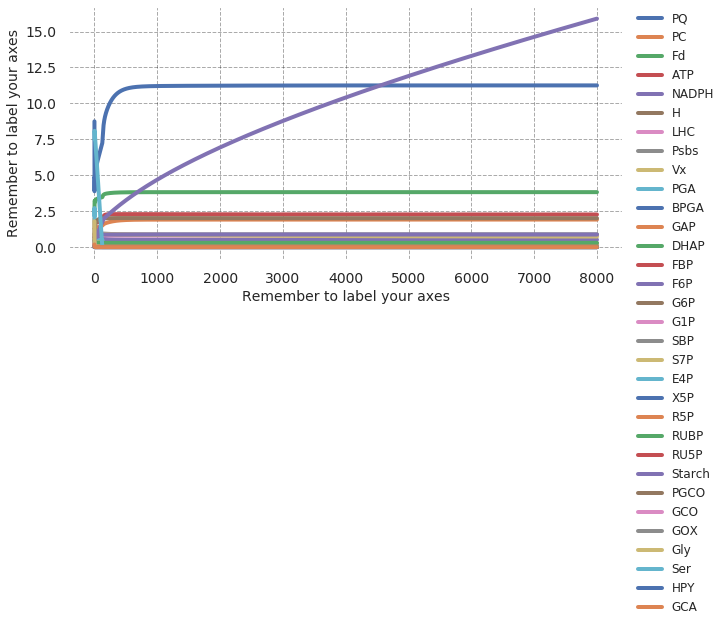

In [22]:
''' Simulation of all metabolite concentrations over time '''
s = Simulator(m)
s.initialise (y0)
m.update_parameters({'O2':0.27,'CO2':0.013,'pfd':100})
#m.update_parameters({'O2':0.0,'CO2':0.2,'pfd':100})
s.simulate(8000, steps=8000, **{'atol':1.e-15})
s.plot();
# every compound reaches a steady state, except for starch which keeps increasing 

### RuBisCO carboxylation and oxygenation rates at different concentrations of CO2 and O2

Figure 9 from the master thesis:

Time course simulations of RuBisCO reaction rates (in mM/s). The blue graph shows the
carboxylation rate, the orange graph shows the oxygenation rate. First plot displays the rates for the
standard conditions of CO2 and O2 concentrations used in the model (CO2: 0,013 mM; O2: 0,27 mM);
Second plot displays the rates for removing oxygen (CO2: 0,013 mM; O2: 0 mM); 
Third plot displays the rates for removing carbon dioxide instead (CO2: 0 mM; O2: 0,27 mM).

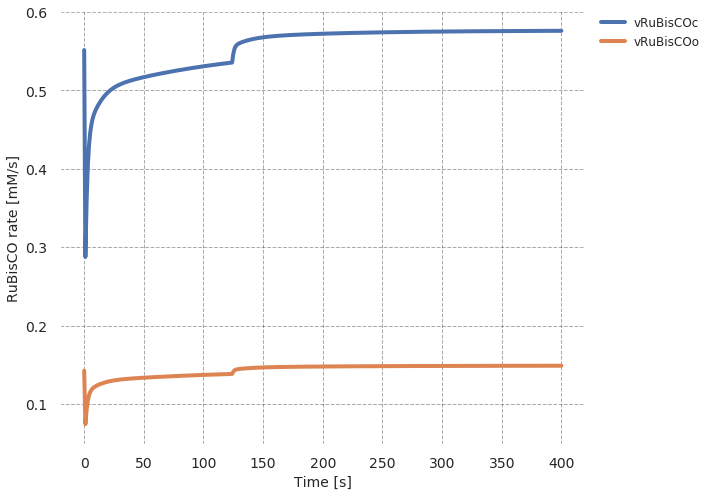

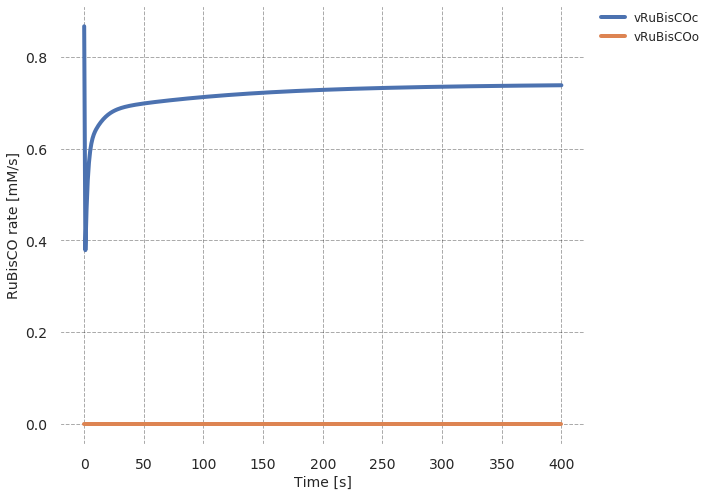

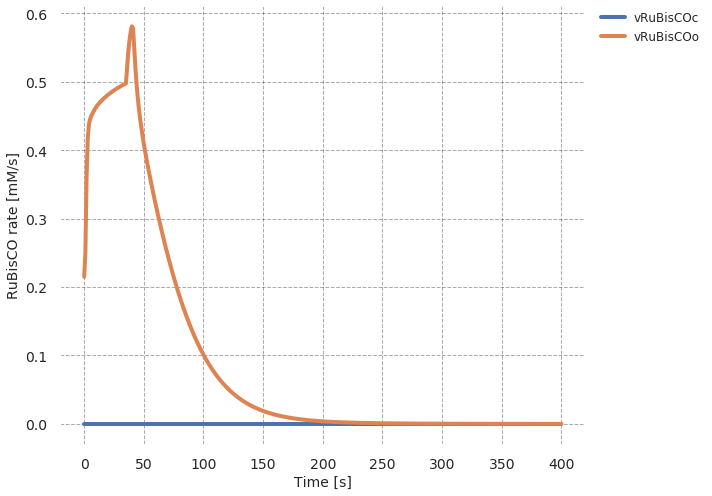

In [14]:
s.initialise(y0)
m.update_parameters({'CO2':0.013, 'O2':0.27})
s.simulate(400, steps=400, **{'atol':1.e-14})
s.plot_flux_selection(["vRuBisCOc","vRuBisCOo"],'normal')
plt.xlabel('Time [s]')
plt.ylabel('RuBisCO rate [mM/s]')

s.initialise(y0)
m.update_parameters({'CO2':0.013, 'O2':0.0})
s.simulate(400, steps=400, **{'atol':1.e-14})
s.plot_flux_selection(["vRuBisCOc","vRuBisCOo"],'no oxygen')
plt.xlabel('Time [s]')
plt.ylabel('RuBisCO rate [mM/s]')

s.initialise(y0)
m.update_parameters({'CO2':0.00, 'O2':0.27})
s.simulate(400, steps=400, **{'atol':1.e-14})
s.plot_flux_selection(["vRuBisCOc","vRuBisCOo"],'no CO2')
plt.xlabel('Time [s]')
plt.ylabel('RuBisCO rate [mM/s]')

plt.show()
m.update_parameters({'CO2':0.013, 'O2':0.27})

### Carbon fixation net rates at varying light intensity and concentrations of CO2 or O2
Figure 10 from the master thesis

Time course simulations of carbon fixation rates (in mM/s) (difference of fixated CO2 by RuBisCO carboxylation and released CO2 by glycine decarboxylase). 
The green graph shows the carbon fixation rate for varying light intensity, the blue graph for increasing CO2 concentration, and the red graph for increasing O2 concentration.

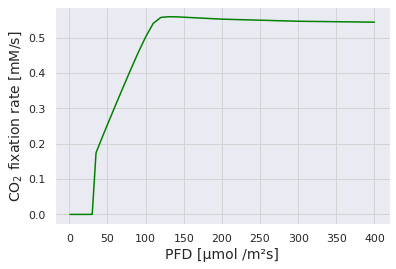

In [15]:
pfdlist = [1,2,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,110,120,130,140,150,160,200,300,400]
m.update_parameters({"CO2":0.013,"O2":0.27,"pfd":100})
fluxes_pfd = []
for i in pfdlist: 
    s = Simulator(m)
    s.initialise(y0)
    m.update_parameters({"pfd":i})
    s.simulate(1000, steps=1000, **{'atol':1.e-14})
    fluxes_pfd.append(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
plt.plot(pfdlist,fluxes_pfd,color='green')
plt.ylabel('CO$_{2}$ fixation rate [mM/s]',fontsize=14.)
plt.xlabel('PFD [µmol /m²s]',fontsize=14.)
plt.grid(color='lightgrey')
plt.show()
m.update_parameters({"pfd":100})

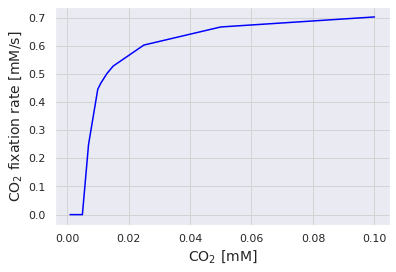

In [16]:
co2list = [0.001,0.003,0.005,0.007,0.01,0.011,0.013,0.015,0.025,0.05,0.1] #CO2
m.update_parameters({"CO2":0.013,"O2":0.27,"pfd":100})
fluxes_co2 = []
for i in co2list:  
    s = Simulator(m)
    s.initialise(y0)
    m.update_parameters({"CO2":i})
    s.simulate(1000, steps=1000, **{'atol':1.e-14})
    fluxes_co2.append(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
plt.plot(co2list,fluxes_co2,color='blue')
plt.ylabel('CO$_{2}$ fixation rate [mM/s]',fontsize=14.)
plt.xlabel('CO$_{2}$ [mM]',fontsize=14.)
plt.grid(color='lightgrey')
plt.show()
m.update_parameters({"CO2":0.013})

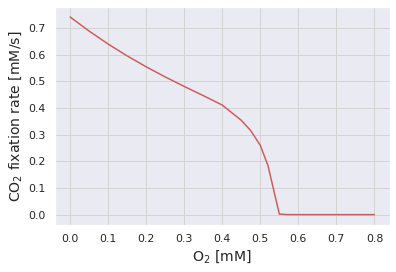

In [17]:
oxylist = [0.000000,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.475,0.5,0.52,0.55,0.57,0.6,0.7,0.75,0.76,0.8] #O2
m.update_parameters({"CO2":0.013,"O2":0.27,"pfd":100})
fluxes_oxy = []
for i in oxylist:   
    s = Simulator(m)
    s.initialise(y0)
    m.update_parameters({"O2":i})
    s.simulate(1000, steps=1000, **{'atol':1.e-14})
    fluxes_oxy.append(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
plt.plot(oxylist,fluxes_oxy,color='indianred')
plt.ylabel('CO$_{2}$ fixation rate [mM/s]',fontsize=14.)
plt.xlabel('O$_{2}$ [mM]',fontsize=14.)
plt.grid(color='lightgrey')
plt.show()
m.update_parameters({"O2":0.27})

## Light-Dark-Light simulations

Figure 13 from the master thesis

Light intensity is changed at different time points: at 300 s the light is "turned off" (PFD = 5 μmol m−2 s−1), after 500 s the light intensity is changed back to its original value (between 20 and 300 PFD). 
The diagrams show the change over time of the internal orthophosphate concentration, the triose phosphate transporter (TPT) rates and the carbon fixation rates.

In [458]:
def LDL(s, y0, Tmax, intensity, darkphase):  
    '''Simple Light-Dark-Light simulation'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity})
    s.simulate(300, steps=600, **{'atol':1.e-14}) #FIXME: this part I hate. I needed to fix integration steps to match Nimas previous work, otherwise doesn't converge
    s.update_parameter('pfd', 5.)
    s.simulate(500, steps=200, **{'atol':1.e-14})  #I needed to make it smaller from the default, otherwise integration problems  
    s.update_parameter('pfd', intensity)
    s.simulate(800, steps=300, **{'atol':1.e-14})
        
    return s, s.model

def LDL_PAM(s, y0, Tmax, intensity, darkphase, Tflash=60.):  
    '''Simple Light-Dark-Light simulation with saturating pulses of light every Tflash seconds'''
        
    s.initialise(y0)
    s.update_parameters({'pfd': intensity, 'Ton': 300, 'Toff':300+darkphase, 'dT': Tflash})

    t=0
    Tmax=1800
    while t < Tmax :   
        #turn on the saturating pulse of light of Tflash length
        if t%s.model.get_parameter('dT') == 0:
            s.update_parameter('pfd', 5000)
            s.simulate(t+0.8)
        else:
            #switch on the light except for the dark period
            #t+dT-Tflash is the time to the next flash
            if t> s.model.get_parameter('Ton') or t<s.model.get_parameter('Toff'):
                s.update_parameter('pfd', 5.)
            else:
                #put the actinic light
                s.update_parameter('pfd', intensity)
            new_t = t+s.model.get_parameter('dT')-0.8
            s.simulate(new_t)  #I needed to make it smaller from the default, otherwise integration problems  
        t = s.get_time()[-1]  
        
    return s, s.model

### Reproduce Fig. 2 from the original paper

For the master thesis, range of the light intensities was increased to 20 - 300 μmol m−2 s−1. 
The carbon fixation rate in the original paper was determined from the RuBisCO carboxylation rate. Here, the rate was determined as the difference between the carbon fixing step of the CBB cycle, the RuBisCO carboxylation, and the reaction step of the photorespiration where CO2 is released, the Glycine decarboxylase reaction. The RU5P resupply from the starch degrading reaction is turned off during recreation of the original diagram, and CO2 and O2 concentrations are set to the original paper's values, 0.2 and 0, respectively.

20
50
100
150
200
250
300


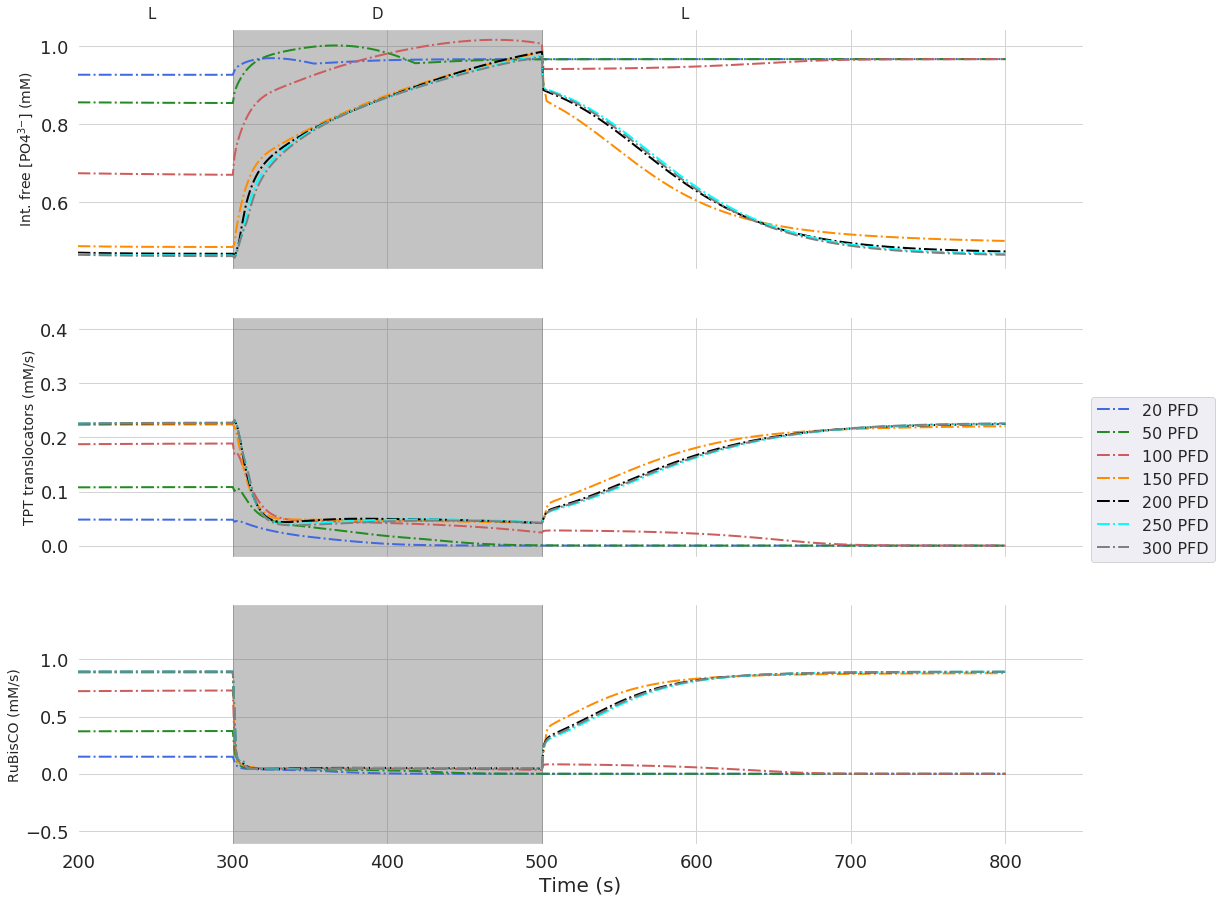

In [460]:
PhosphoMAX=15
m.update_parameters({'O2': 0., 'CO2': 0.2, 'vstx':0.})

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=14.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=14.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=14.)

ax[2].set_xlabel('Time (s)',fontsize=20.)

col = {20:'royalblue',50:'forestgreen',100:'indianred',150:'darkorange',200:'black',250:'cyan',300:'grey'}

for i in [20, 50, 100, 150, 200, 250, 300]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200.)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCOc']-s.get_fluxes_dict()['vR4']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+' PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+' PFD',zorder=10.)

ax[1].legend(loc='best',bbox_to_anchor=(1., 0.7), prop={'size': 16})

plt.show()
m.update_parameters({'O2': 0.27, 'CO2': 0.013, 'vstx':0.296})

### LDL plots for the photorespiration model

20
50
100
150
200
250
300


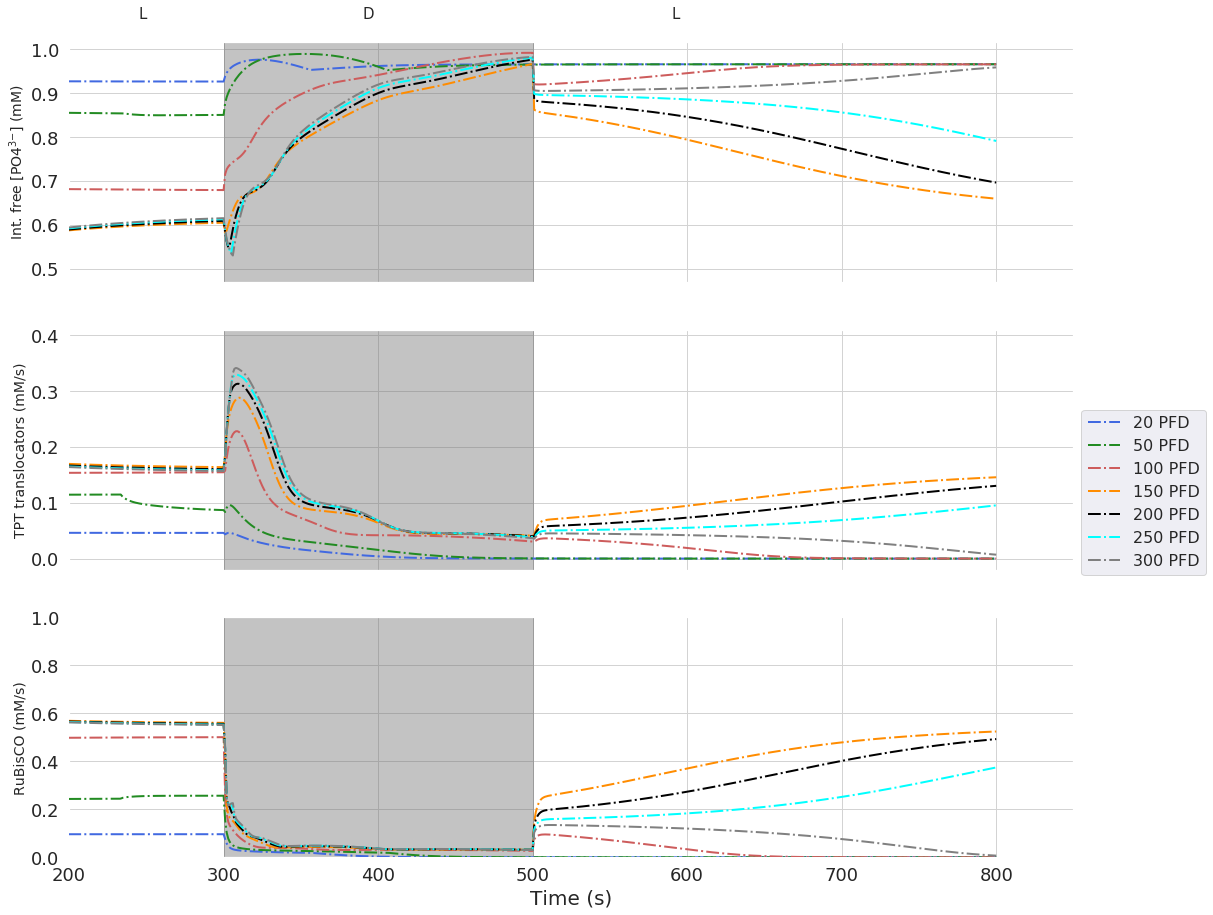

In [40]:
PhosphoMAX=15
m.update_parameters({'O2': 0.27, 'CO2': 0.013})

fig, ax = plt.subplots(3,1, sharex=True)
plt.rcParams["figure.figsize"] = (18, 15)
for (aa), subplot in np.ndenumerate(ax):
    subplot.set_xlim(200,850)
    subplot.axvspan(300,500,alpha=0.4,color='dimgray')
    subplot.set_facecolor('white')
    subplot.grid(color='lightgrey')
    subplot.tick_params(axis='both', which='major', labelsize=18)


ax[0].set_ylabel('Int. free [PO4$^{3−}$] (mM)',fontsize=14.)
ax[0].text(245,1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(390, 1.07, 'D', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[0].text(590, 1.07, 'L', fontsize=15,bbox={'facecolor':'w', 'alpha':0.5, 'pad':3})
ax[1].set_ylabel('TPT translocators (mM/s)',fontsize=14.)
ax[2].set_ylabel('RuBisCO (mM/s)',fontsize=14.)
ax[2].set_xlabel('Time (s)',fontsize=20.)
ax[2].set_ylim((0,1.))

col = {20:'royalblue',50:'forestgreen',100:'indianred',150:'darkorange',200:'black',250:'cyan',300:'grey'}

for i in [20, 50, 100, 150, 200, 250, 300]: 
    print(i)

    s = Simulator(m)
    s.initialise(y0)
    s, m = LDL(s, y0, Tmax=500, intensity=i,darkphase=200.)

    yvex1=s.get_fluxes_dict()['vpga']+s.get_fluxes_dict()['vgap']+s.get_fluxes_dict()['vdhap']
    yrub1=s.get_fluxes_dict()['vRuBisCOc']-s.get_fluxes_dict()['vR4']

    ax[0].plot(s.get_time(),s.get_variable('Pi')/PhosphoMAX,color=col[i],linestyle='-.',linewidth=2.,label=str(i)+'PFD',zorder=10.)
    ax[1].plot(s.get_time(),yvex1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+' PFD',zorder=10.)
    ax[2].plot(s.get_time(),yrub1, color=col[i],linestyle='-.',linewidth=2.,label=str(i)+' PFD',zorder=10.)

ax[1].legend(loc='best',bbox_to_anchor=(1., 0.7), prop={'size': 16})

plt.show()
m.update_parameters({'O2': 0.27, 'CO2': 0.013})

### Analysis of RU5P supply
Figure 11 from the master thesis

Simulation displaying ribulose-5-phosphate (RU5P) concentration (in μM) for different initial
concentrations of RU5P (0,9-1 mM). The graphs are displayed after 5 s, when CBB compounds have
equilibrated. As can be seen by the dashed line, initial concentrations below 0,98 mM of RU5P lead to
collapse of the system

In [362]:
# Set initial conditions using dictionary
init_RU5P = {
        "PQ":m.get_parameter('PQtot')/2,
        "PC":m.get_parameter('PCtot')/2,
        "Fd":m.get_parameter('Fdtot')/2,
        "ATP":0.12,
        "NADPH":0.281543418344,
        "H":calculate_pHinv(7.2),
        "LHC":0.9,
        "Psbs":0.9,
        "Vx":0.9,
        "PGA":0.,
        'BPGA':0.0,
        'GAP':0.0,
        'DHAP':0.,
        'FBP':0.,
        'F6P':0.,
        'G6P':0.,
        'G1P':0.,
        'SBP':0.,
        'S7P':0.,
        'E4P':0.,
        'X5P':0.,
        'R5P':0.,
        'RUBP':0.,
        'RU5P':.2,
        'Starch':0.0,
        'PGCO':0.,
        'GCO':0., 
        'GOX':0., 
        'Gly':0.,  # 0.6 
        'Ser':0.,  # 4.3 
        'HPY':0., 
        'GCA':0.,
}

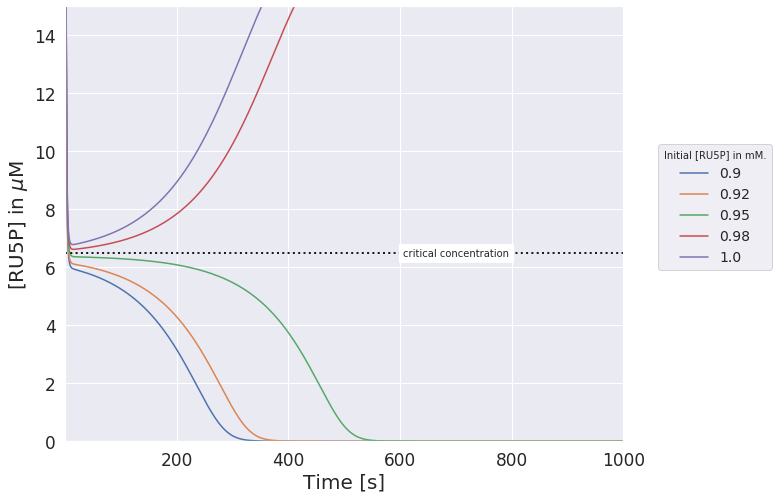

In [369]:
init_ru5p=np.round(np.linspace(0.9,1,5),2)
m.update_parameters({'O2': 0.27, 'CO2': 0.013,'pfd':100, 'vstx':0})

fig = plt.figure()
plt.rcParams["figure.figsize"] = (10, 8)
ax1 = fig.add_subplot(111)
#s.model.update_parameter('pfd', 300)

for i in init_ru5p:
    init_RU5P['RU5P']=i
    s = Simulator(m)
    s.initialise(init_RU5P)
    s.simulate(3000, **{'atol': 1.e-16})
    ax1.plot(s.get_time(),s.get_variable('RU5P')*1000, label=str(i))
    
ax1.axhline(6.5,color='k',linewidth=2.,linestyle=':')  
plt.text(700, 6.5, 'critical concentration', fontsize=10, va='center', ha='center', backgroundcolor='w')
ax1.set_ylabel('[RU5P] in $\mu$M',fontsize=20.)

ax1.tick_params(axis='both', which='major', labelsize=17)
ax1.set_xlabel('Time [s]',fontsize=20.)
ax1.legend(title=r'Initial [RU5P] in mM.', loc='best',bbox_to_anchor=(1.05, 0.7), prop={'size': 14})
ax1.set_xlim((5,1000))
ax1.set_ylim((0,15.))

plt.show()

m.update_parameters({'O2': 0.27, 'CO2': 0.013,'pfd':100, 'vstx':0.296})

Figure 12 from the master thesis

Steady state simulations under increasing influx of RU5P, under low light conditions
(5 μmol m−2 s−1). Plotted were the ATP abundance compared to total adenosine phosphate pool, the RU5P
concentration (in mM), the luminal pH value, and the net carbon fixation rate (in mM/s)

In [18]:
mox =  copy.deepcopy(m) # copy the model

In [19]:
from modelbase.ode import ratelaws as rl

mox.add_reaction_from_ratelaw(rate_name="voxPPP", ratelaw=rl.Constant(product="RU5P", k="oxPPP"))

In [372]:
oxPPP_list=np.concatenate((np.linspace(0, 0.01, 10), np.linspace(0.01,0.075,10))) 
s.update_parameters({'O2': 0.27, 'CO2': 0.013, 'pfd':5, 'vstx':0})

res_list=[]
res_list_ru5p=[]
res_list_H=[]
res_list_nadph=[]
res_list_CO2=[]

for i in oxPPP_list:
    s = Simulator(mox)
    s.initialise(y0)

    mox.update_parameters({'pfd':5., 'oxPPP':i})
    s.simulate(1500, steps=1500, **{'atol':1.e-14})

    atpCC=s.get_variable('ATP')
    res_list.append((atpCC[-1]/mox.get_parameter('APtot')))
    ru5pCC=s.get_variable('RU5P')
    res_list_ru5p.append(ru5pCC[-1])
    protonsOX=s.get_variable('H')
    #print(protonsOX[-1])
    res_list_H.append((-np.log(protonsOX[-1]*(2.5e-4))/np.log(10)))
    nadphox=s.get_variable('NADPH')[-1]
    res_list_nadph.append(nadphox/m.get_parameter('NADPtot'))    
    res_list_CO2.append(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])

1.7002444286920182
1.604690583785913
1.3993598472392372
0.8309060096757671
0.004472914924901861
0.0037190829068167665
0.0033333765545139928
0.003074624069851335
0.0028800646418540017
0.0027242220709331588
0.0027242220709331588
0.0021172934485274514
0.001782536700324637
0.0015704595121139701
0.001477478523015455
0.0013309582133752352
0.0012052031625134386
0.0010966306425725162
0.0009960555535346288
0.0008994512787270969


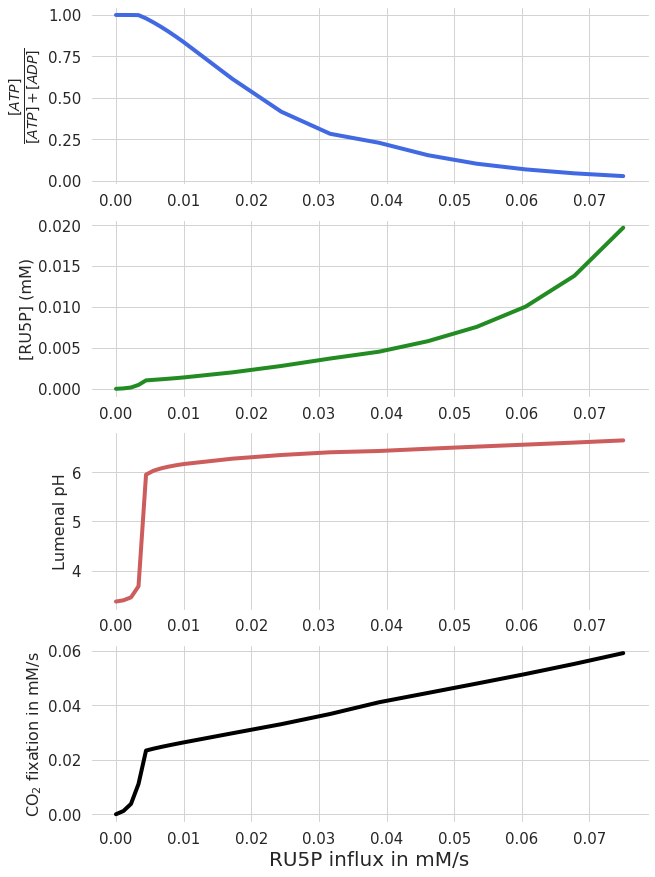

In [377]:
# Plot the results

fig = plt.figure()
ax1 = fig.add_subplot(411)
plt.rcParams["figure.figsize"] = (10, 15)
ax1.plot(oxPPP_list,res_list,color='royalblue',linewidth=4.)
ax1.set_ylabel(r'$\frac{[ATP]}{[ATP]+[ADP]}$',fontsize=20.)
ax1.set_facecolor('white')
ax1.grid(color='lightgrey')
ax1.tick_params(axis='both', which='major', labelsize=15)


ax2 = fig.add_subplot(412)
ax2.plot(oxPPP_list,res_list_ru5p,color='forestgreen',linewidth=4.)
#ax2.plot(oxPPP_list,np.full(len(oxPPP_list),0.00248),color='k',linewidth=2.,linestyle=':',label='Critical Concentration')
#ax2.legend(loc='best', prop={'size': 15})
ax2.set_ylabel('[RU5P] (mM)',fontsize=16.)
ax2.set_facecolor('white')
ax2.grid(color='lightgrey')
ax3 = fig.add_subplot(413)
ax3.plot(oxPPP_list,res_list_H,color='indianred',linewidth=4.)
ax3.set_ylabel('Lumenal pH',fontsize=16.)
ax3.set_facecolor('white')
ax3.grid(color='lightgrey')

ax4 = fig.add_subplot(414)
ax4.plot(oxPPP_list,res_list_CO2, color='black',linewidth=4.)
ax4.set_ylabel('CO$_{2}$ fixation in mM/s ',fontsize=16.)
ax4.set_xlabel('RU5P influx in mM/s',fontsize=20.)
ax4.set_facecolor('white')
ax4.grid(color='lightgrey')

ax2.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax4.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### Steady state changes for varying multiple variable

Figure 14 from the master thesis:

3D plots with systematic variation of cycle velocity (fCBB) and light intensity (μmol m −2 s −1).
From top left to bottom right: 
1) ATP abundance, 2) TPT activity (mM/s), 3) starch synthesis rate (mM/s), 4) Lumenal pH, 5) carbon net assimilation rate (mM/s), 6) photorespiration rate (mM/s), 7) linear electron flow (mM/s), 8) cyclic electron flow (mM/s)

In [390]:
PFDs=np.array([1.,2.,5.,8.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.,200.,300.,400.,500.,600.,700])
Xs=np.round(np.linspace(1.,10.,10),1)

ATPval = []
Starchval = []
phval = []
rateval = []
carbfixval = []
PETCval = []
cycval = []
PRval = []
s.update_parameters({'O2': 0.27, 'CO2': 0.013, 'pfd':100})
    
for X in Xs:
    speicherX=[]
    speich_starch=[]
    speich_H=[]
    res_list_vex=[]
    carbfix = []
    PETClist = []
    cyclist = []
    PRlist = []
    s.update_parameters({'vcmax':2.913930914*8*X,'vomax':2.913930914*0.24*8*X,'V6':0.2*8*X,'V9':0.04*8*X,'V13':0.9999*8*X,
                         'Vst':0.04*8*X,'v1r':52.4199*8*X,'v2r':1.45611*8*X,'v3r':2.74582*8*X,'v4r':2.49475*8*X})

    for i in PFDs:
        print(X, i)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter('pfd', i)
        s.simulate(50, steps=50, **{'atol': 1.e-14})
        s.simulate(100, steps=100, **{'atol': 1.e-14})
        s.simulate(187, steps=187, **{'atol': 1.e-14})
        s.simulate(198, steps=198, **{'atol': 1.e-14})
        s.simulate(200, steps=200, **{'atol': 1.e-14})
        s.simulate(300, steps=300, **{'atol': 1.e-14})
        s.simulate(367, steps=367, **{'atol': 1.e-14})
        s.simulate(400, steps=400, **{'atol': 1.e-14})
        s.simulate(430, steps=430, **{'atol': 1.e-14})
        s.simulate(450, steps=450, **{'atol': 1.e-14})
        s.simulate(460, steps=460, **{'atol': 1.e-14})
        s.simulate(470, steps=470, **{'atol': 1.e-14})
        s.simulate(480, steps=480, **{'atol': 1.e-14})
        s.simulate(490, steps=490, **{'atol': 1.e-14})
        s.simulate(500, steps=500, **{'atol': 1.e-14})

        h=s.get_variable('H')

        speicherX.append(s.get_variable('ATP')[-1])
        speich_starch.append(s.get_fluxes_dict()['vStarch'][-1])
        speich_H.append(calculate_pH(s.get_variable('H')[-1]))
        VEX=(s.get_fluxes_dict()['vpga'][-1]+s.get_fluxes_dict()['vgap'][-1]+s.get_fluxes_dict()['vdhap'][-1])
        res_list_vex.append(VEX) 
        COfix=(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
        carbfix.append(COfix)
        PETClist.append(s.get_fluxes_dict()['vPS2'][-1])
        cyclist.append(s.get_fluxes_dict()['vCyc'][-1])
        PRlist.append(s.get_fluxes_dict()['vRuBisCOo'][-1])        
        
    ATPval.append(speicherX)
    Starchval.append(speich_starch)
    phval.append(speich_H)
    rateval.append(res_list_vex)
    carbfixval.append(carbfix)
    PETCval.append(PETClist)
    cycval.append(cyclist)
    PRval.append(PRlist)
    
ATPval=np.array(ATPval)/2.55 # normalization
Starchval=np.array(Starchval)
phval=np.array(phval)
rateval=np.array(rateval)
carbfixval=np.array(carbfixval)
PETCval=np.array(PETCval)
cycval=np.array(cycval)
PRval=np.array(PRval)

output_dict={'ATP':ATPval,'TPT':rateval,'Starch':Starchval, 'pH':phval, 'RuBisCO carboxylation':carbfixval,
             'RuBisCO oxygenation':PRval,'PSII':PETCval, 'cyclic electron flow':cycval}

1.0 1.0
1.0 2.0
1.0 5.0
1.0 8.0
1.0 10.0
1.0 20.0
1.0 30.0
1.0 40.0
1.0 50.0
1.0 60.0
1.0 70.0
1.0 80.0
1.0 90.0
1.0 100.0
1.0 200.0
1.0 300.0
1.0 400.0
1.0 500.0
1.0 600.0
1.0 700.0
2.0 1.0
2.0 2.0
2.0 5.0
2.0 8.0
2.0 10.0
2.0 20.0
2.0 30.0
2.0 40.0
2.0 50.0
2.0 60.0
2.0 70.0
2.0 80.0
2.0 90.0
2.0 100.0
2.0 200.0
2.0 300.0
2.0 400.0
2.0 500.0
2.0 600.0
2.0 700.0
3.0 1.0
3.0 2.0
3.0 5.0
3.0 8.0
3.0 10.0
3.0 20.0
3.0 30.0
3.0 40.0
3.0 50.0
3.0 60.0
3.0 70.0
3.0 80.0
3.0 90.0
3.0 100.0
3.0 200.0
3.0 300.0
3.0 400.0
3.0 500.0
3.0 600.0
3.0 700.0
4.0 1.0
4.0 2.0
4.0 5.0
4.0 8.0
4.0 10.0
4.0 20.0
4.0 30.0
4.0 40.0
4.0 50.0
4.0 60.0
4.0 70.0
4.0 80.0
4.0 90.0
4.0 100.0
4.0 200.0
4.0 300.0
4.0 400.0
4.0 500.0
4.0 600.0
4.0 700.0
5.0 1.0
5.0 2.0
5.0 5.0
5.0 8.0
5.0 10.0
5.0 20.0
5.0 30.0
5.0 40.0
5.0 50.0
5.0 60.0
5.0 70.0
5.0 80.0
5.0 90.0
5.0 100.0
5.0 200.0
5.0 300.0
5.0 400.0
5.0 500.0
5.0 600.0
5.0 700.0
6.0 1.0
6.0 2.0
6.0 5.0
6.0 8.0
6.0 10.0
6.0 20.0
6.0 30.0
6.0 40.0
6.0 50.0
6.0 60.0

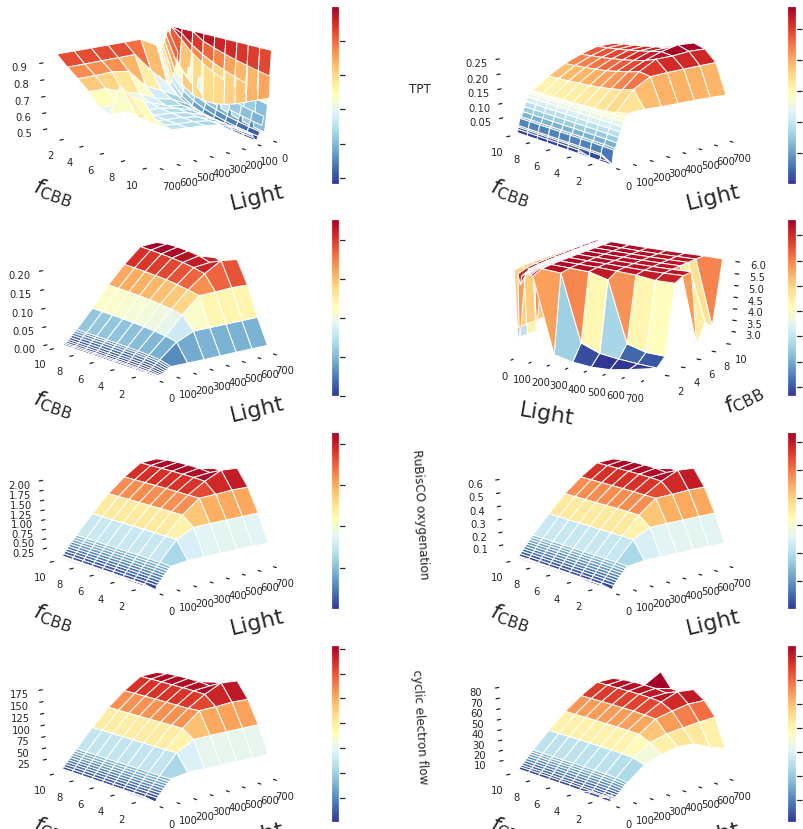

In [445]:
hf = plt.figure()
plt.rcParams["figure.figsize"] = (15, 15)

j=1

for i in output_dict:
    ha = hf.add_subplot(4,2,j, projection='3d')

    X, Y = np.meshgrid(PFDs, Xs) 
    
    Z=output_dict[i]

    Gx, Gy = np.gradient(Z) 
    G = (Gx**2+Gy**2)**.5  
    N = G/G.max()  

    surf=ha.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.RdYlBu_r,linewidth=1, antialiased=True,alpha=1.)

    cb=hf.colorbar(surf)
    cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=10)

    ha.set_xlabel('Light', labelpad=20.2,fontsize=22., rotation=45)
    ha.set_ylabel(r'$f_\mathrm{CBB}$', labelpad=20.2,fontsize=22.)
    ha.tick_params(labelsize=10)
    ha.set_facecolor('white')

    if i in ['TPT', 'Starch','RuBisCO oxygenation','RuBisCO carboxylation','PSII','cyclic electron flow']:
        ha.view_init(elev=25., azim=230)
    elif i == 'pH':
         ha.view_init(elev=25., azim=-60)
    elif i == 'ATP':
         ha.view_init(elev=25., azim=50)

    ha.set_zlabel(i, labelpad=21.2,fontsize=12.)
    ha.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ha.zaxis.grid('true',color='b')
    j = j + 1
    
#fig.tight_layout() # optional to reduce the space between subplots
plt.show()

Figure 15 from the master thesis:

3D plots with systematic variation of oxygen concentration (mM) and light intensity (μmol m −2 s −1).
From top left to bottom right: 
1) ATP abundance, 2) TPT activity (mM/s), 3) starch synthesis rate (mM/s), 4) Lumenal pH, 5) carbon net assimilation rate (mM/s), 6) photorespiration rate (mM/s), 7) linear electron flow (mM/s), 8) cyclic electron flow (mM/s)

In [406]:
ATPval = []
Starchval = []
phval = []
rateval = []
carbfixval = []
PETCval = []
cycval = []
PRval = []
s.update_parameters({'CO2': 0.013, 'O2':0.27, 'pfd':100})
s.update_parameters({'vcmax':2.913930914*8,'vomax':2.913930914*0.24*8,'V6':0.2*8,'V9':0.04*8,'V13':0.9999*8,
                    'Vst':0.04*8,'v1r':52.4199*8,'v2r':1.45611*8,'v3r':2.74582*8,'v4r':2.49475*8})

PFDs=np.array([1.,2.,5.,10.,20.,30.,40.,50.,60.,70.,80.,100.,150.,200.,250.,300.,400.,500.,600.,700])
O2s=np.round(np.linspace(0.,0.8,9),2)

for X in O2s:
    speicherX=[]
    speich_starch=[]
    speich_H=[]
    res_list_vex=[]
    carbfix=[]
    PETClist = []
    cyclist = []
    PRlist = []
    s.update_parameters({'O2': X})

    for i in PFDs:
        print(X, i)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter('pfd', i)
        s.simulate(500, steps=500, **{'atol': 1.e-14})

        h=s.get_variable('H')

        speicherX.append(s.get_variable('ATP')[-1])
        speich_starch.append(s.get_fluxes_dict()['vStarch'][-1])
        speich_H.append(calculate_pH(s.get_variable('H')[-1]))
        VEX=(s.get_fluxes_dict()['vpga'][-1]+s.get_fluxes_dict()['vgap'][-1]+s.get_fluxes_dict()['vdhap'][-1])
        res_list_vex.append(VEX) 
        COfix=(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
        carbfix.append(COfix)
        PETClist.append(s.get_fluxes_dict()['vPS2'][-1])
        cyclist.append(s.get_fluxes_dict()['vCyc'][-1])
        PRlist.append(s.get_fluxes_dict()['vRuBisCOo'][-1]) 

    ATPval.append(speicherX)
    Starchval.append(speich_starch)
    phval.append(speich_H)
    rateval.append(res_list_vex)
    carbfixval.append(carbfix)
    PETCval.append(PETClist)
    cycval.append(cyclist)
    PRval.append(PRlist)

ATPval=np.array(ATPval)/2.55 # normalization
Starchval=np.array(Starchval)
phval=np.array(phval)
rateval=np.array(rateval)
carbfixval=np.array(carbfixval)
PETCval=np.array(PETCval)
cycval=np.array(cycval)
PRval=np.array(PRval)

output_dict2={'ATP':ATPval,'TPT':rateval,'Starch':Starchval, 'pH':phval, 'RuBisCO carboxylation':carbfixval,
             'RuBisCO oxygenation':PRval,'PSII':PETCval, 'cyclic electron flow':cycval}

0.0 1.0
0.0 2.0
0.0 5.0
0.0 10.0
0.0 20.0
0.0 30.0
0.0 40.0
0.0 50.0
0.0 60.0
0.0 70.0
0.0 80.0
0.0 100.0
0.0 150.0
0.0 200.0
0.0 250.0
0.0 300.0
0.0 400.0
0.0 500.0
0.0 600.0
0.0 700.0
0.1 1.0
0.1 2.0
0.1 5.0
0.1 10.0
0.1 20.0
0.1 30.0
0.1 40.0
0.1 50.0
0.1 60.0
0.1 70.0
0.1 80.0
0.1 100.0
0.1 150.0
0.1 200.0
0.1 250.0
0.1 300.0
0.1 400.0
0.1 500.0
0.1 600.0
0.1 700.0
0.2 1.0
0.2 2.0
0.2 5.0
0.2 10.0
0.2 20.0
0.2 30.0
0.2 40.0
0.2 50.0
0.2 60.0
0.2 70.0
0.2 80.0
0.2 100.0
0.2 150.0
0.2 200.0
0.2 250.0
0.2 300.0
0.2 400.0
0.2 500.0
0.2 600.0
0.2 700.0
0.3 1.0
0.3 2.0
0.3 5.0
0.3 10.0
0.3 20.0
0.3 30.0
0.3 40.0
0.3 50.0
0.3 60.0
0.3 70.0
0.3 80.0
0.3 100.0
0.3 150.0
0.3 200.0
0.3 250.0
0.3 300.0
0.3 400.0
0.3 500.0
0.3 600.0
0.3 700.0
0.4 1.0
0.4 2.0
0.4 5.0
0.4 10.0
0.4 20.0
0.4 30.0
0.4 40.0
0.4 50.0
0.4 60.0
0.4 70.0
0.4 80.0
0.4 100.0
0.4 150.0
0.4 200.0
0.4 250.0
0.4 300.0
0.4 400.0
0.4 500.0
0.4 600.0
0.4 700.0
0.5 1.0
0.5 2.0
0.5 5.0
0.5 10.0
0.5 20.0
0.5 30.0
0.5 40.0
0.5 50.0
0

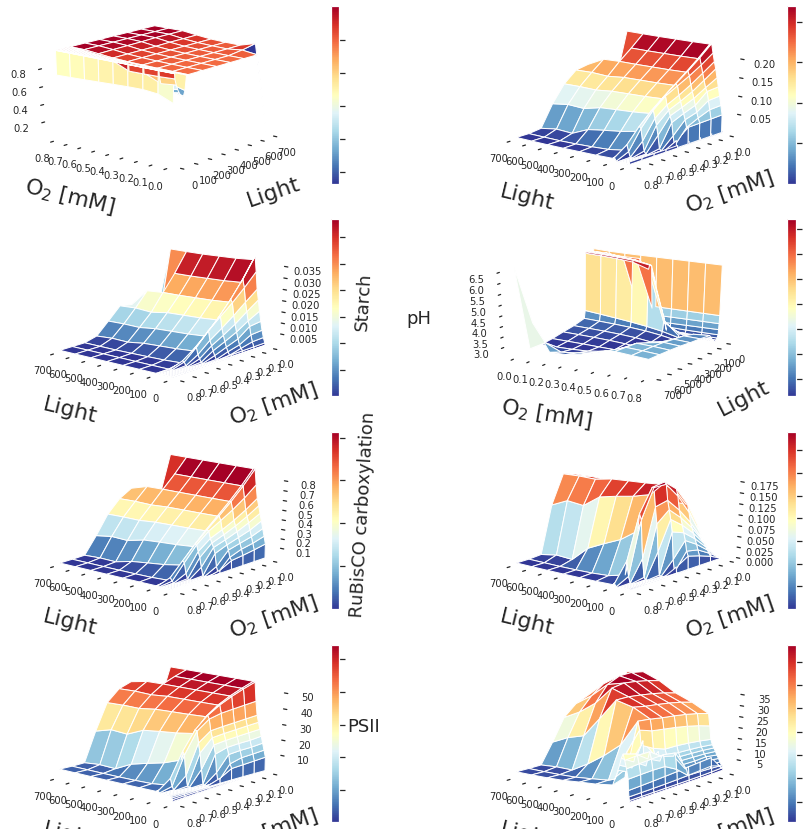

In [442]:
hf = plt.figure()
plt.rcParams["figure.figsize"] = (15, 15)

j=1

for i in output_dict2:
    ha = hf.add_subplot(4,2,j, projection='3d')

    X, Y = np.meshgrid(PFDs, O2s) 
    
    Z=output_dict2[i]

    Gx, Gy = np.gradient(Z) 
    G = (Gx**2+Gy**2)**.5  
    N = G/G.max()  

    surf=ha.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.RdYlBu_r,linewidth=1, antialiased=True,alpha=1.)

    cb=hf.colorbar(surf)
    cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=10)

    ha.set_xlabel('Light', labelpad=20.2,fontsize=22., rotation=45)
    ha.set_ylabel('O$_{2}$ [mM]', labelpad=20.2,fontsize=22.)
    ha.tick_params(labelsize=10)
    ha.set_facecolor('white')

    if i in ['TPT', 'Starch','PSII', 'cyclic electron flow', 'RuBisCO oxygenation','RuBisCO carboxylation']:
        ha.view_init(elev=25., azim=130)
    elif i == 'ATP':
         ha.view_init(elev=25., azim=220) 
    elif i == 'pH':
         ha.view_init(elev=25., azim=30)       

    ha.set_zlabel(i, labelpad=21.2,fontsize=18.)
    ha.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ha.zaxis.grid('true',color='b')
    j = j + 1
    
#fig.tight_layout() # optional to reduce the space between subplots
plt.show()

Figure 16 from the master thesis:

3D plots with systematic variation of oxygen concentration (mM) and CO2 concentration (mM).
From top left to bottom right: 
1) ATP abundance, 2) TPT activity (mM/s), 3) starch synthesis rate (mM/s), 4) Lumenal pH, 5) carbon net assimilation rate (mM/s), 6) photorespiration rate (mM/s), 7) linear electron flow (mM/s), 8) cyclic electron flow (mM/s)

In [191]:
ATPval = []
Starchval = []
phval = []
rateval = []
carbfixval = []
PETCval = []
cycval = []
PRval = []
s.update_parameters({'CO2': 0.013, 'O2':0.27, 'pfd':100})
s.update_parameters({'vcmax':2.913930914*8,'vomax':2.913930914*0.24*8,'V6':0.2*8,'V9':0.04*8,'V13':0.9999*8,
                    'Vst':0.04*8,'v1r':52.4199*8,'v2r':1.45611*8,'v3r':2.74582*8,'v4r':2.49475*8})

CO2s=np.round(np.linspace(0.,0.1,11),2)
O2s=np.round(np.linspace(0.,1,11),2)

for X in O2s:
    speicherX=[]
    speich_starch=[]
    speich_H=[]
    res_list_vex=[]
    carbfix=[]
    PETClist = []
    cyclist = []
    PRlist = []
    s.update_parameters({'O2': X})

    for i in CO2s:
        print(X, i)
        s = Simulator(m)
        s.initialise(y0)
        s.update_parameter('CO2', i)
        s.simulate(600, steps=600, **{'atol': 1.e-14})

        h=s.get_variable('H')

        speicherX.append(s.get_variable('ATP')[-1])
        speich_starch.append(s.get_fluxes_dict()['vStarch'][-1])
        speich_H.append(calculate_pH(s.get_variable('H')[-1]))
        VEX=(s.get_fluxes_dict()['vpga'][-1]+s.get_fluxes_dict()['vgap'][-1]+s.get_fluxes_dict()['vdhap'][-1])
        res_list_vex.append(VEX) 
        COfix=(s.get_fluxes_dict()['vRuBisCOc'][-1]-s.get_fluxes_dict()['vR4'][-1])
        carbfix.append(COfix)
        PETClist.append(s.get_fluxes_dict()['vPS2'][-1])
        cyclist.append(s.get_fluxes_dict()['vCyc'][-1])
        PRlist.append(s.get_fluxes_dict()['vRuBisCOo'][-1]) 

    ATPval.append(speicherX)
    Starchval.append(speich_starch)
    phval.append(speich_H)
    rateval.append(res_list_vex)
    carbfixval.append(carbfix)
    PETCval.append(PETClist)
    cycval.append(cyclist)
    PRval.append(PRlist)

ATPval=np.array(ATPval)/2.55 # normalization
Starchval=np.array(Starchval)
phval=np.array(phval)
rateval=np.array(rateval)
carbfixval=np.array(carbfixval)
PETCval=np.array(PETCval)
cycval=np.array(cycval)
PRval=np.array(PRval)

output_dict3={'ATP':ATPval, 'TPT':rateval, 'Starch':Starchval, 'pH':phval, 'RuBisCO carboxylation':carbfixval,
             'RuBisCO oxygenation':PRval, 'PSII':PETCval, 'cyclic electron flow':cycval}

0.0 0.0
0.0 0.01
0.0 0.02
0.0 0.03
0.0 0.04
0.0 0.05
0.0 0.06
0.0 0.07
0.0 0.08
0.0 0.09
0.0 0.1
0.1 0.0
0.1 0.01
0.1 0.02
0.1 0.03
0.1 0.04
0.1 0.05
0.1 0.06
0.1 0.07
0.1 0.08
0.1 0.09
0.1 0.1
0.2 0.0
0.2 0.01
0.2 0.02
0.2 0.03
0.2 0.04
0.2 0.05
0.2 0.06
0.2 0.07
0.2 0.08
0.2 0.09
0.2 0.1
0.3 0.0
0.3 0.01
0.3 0.02
0.3 0.03
0.3 0.04
0.3 0.05
0.3 0.06
0.3 0.07
0.3 0.08
0.3 0.09
0.3 0.1
0.4 0.0
0.4 0.01
0.4 0.02
0.4 0.03
0.4 0.04
0.4 0.05
0.4 0.06
0.4 0.07
0.4 0.08
0.4 0.09
0.4 0.1
0.5 0.0
0.5 0.01
0.5 0.02
0.5 0.03
0.5 0.04
0.5 0.05
0.5 0.06
0.5 0.07
0.5 0.08
0.5 0.09
0.5 0.1
0.6 0.0
0.6 0.01
0.6 0.02
0.6 0.03
0.6 0.04
0.6 0.05
0.6 0.06
0.6 0.07
0.6 0.08
0.6 0.09
0.6 0.1
0.7 0.0
0.7 0.01
0.7 0.02
0.7 0.03
0.7 0.04
0.7 0.05
0.7 0.06
0.7 0.07
0.7 0.08
0.7 0.09
0.7 0.1
0.8 0.0
0.8 0.01
0.8 0.02
0.8 0.03
0.8 0.04
0.8 0.05
0.8 0.06
0.8 0.07
0.8 0.08
0.8 0.09
0.8 0.1
0.9 0.0
0.9 0.01
0.9 0.02
0.9 0.03
0.9 0.04
0.9 0.05
0.9 0.06
0.9 0.07
0.9 0.08
0.9 0.09
0.9 0.1
1.0 0.0
1.0 0.01
1.0 0.02
1.0 

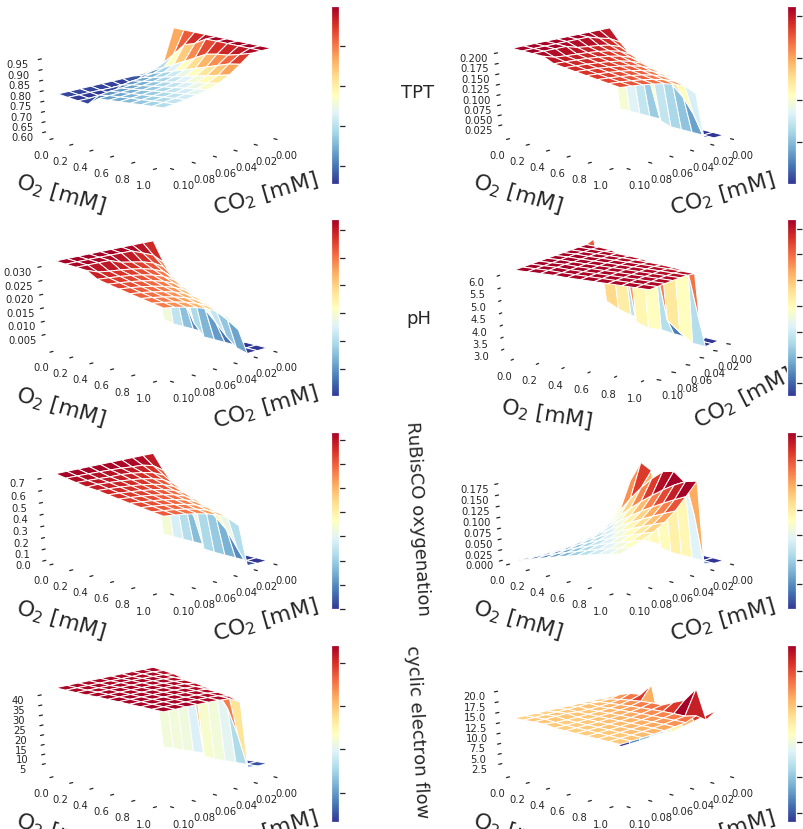

In [193]:
hf = plt.figure()
plt.rcParams["figure.figsize"] = (15, 15)

j=1

for i in output_dict3:
    ha = hf.add_subplot(4,2,j, projection='3d')

    X, Y = np.meshgrid(CO2s, O2s) 
    
    Z=output_dict3[i]

    Gx, Gy = np.gradient(Z) 
    G = (Gx**2+Gy**2)**.5  
    N = G/G.max()  

    surf=ha.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.RdYlBu_r,linewidth=1, antialiased=True,alpha=1.)

    cb=hf.colorbar(surf)
    cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=10)

    ha.set_xlabel('CO$_{2}$ [mM]', labelpad=20.2,fontsize=22., rotation=45)
    ha.set_ylabel('O$_{2}$ [mM]', labelpad=20.2,fontsize=22.)
    ha.tick_params(labelsize=10)
    ha.set_facecolor('white')

    if i in ['TPT','ATP','Starch','PSII','RuBisCO oxygenation','RuBisCO carboxylation','cyclic electron flow']:
        ha.view_init(elev=25., azim=45)
    elif i == 'pH':
         ha.view_init(elev=25., azim=30)       

    ha.set_zlabel(i, labelpad=21.2,fontsize=18.)
    ha.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ha.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    ha.zaxis.grid('true',color='b')
    j = j + 1
    
#fig.tight_layout() # optional to reduce the space between subplots
plt.show()

### Metabolic control analysis

defining function for response coefficients:

In [24]:
def response_coefficient(s, par, CBBspeed=1.,lightintensity=100.,kcyc=1., var=0.01):   
    s.update_parameters({'vcmax':2.913930914*8*CBBspeed, 'vomax':2.913930914*0.24*8*CBBspeed, 
                         'V6' : 0.2*8*CBBspeed, 'V9' : 0.04*8*CBBspeed, 'V13' : 0.9999*8*CBBspeed, 
                         'Vst' : 0.04*8*CBBspeed,'kcyc' : kcyc,
                         'v1r':52.4199*8*CBBspeed, 'v2r':1.45611*8*CBBspeed, 'v3r':2.74582*8*CBBspeed,
                         'v4r':2.49475*8*CBBspeed, 'pfd':lightintensity})
    
    Y={}
    X={}
    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    
    for rate in m.get_rate_names():
        X.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y.update({compd:s.get_results_dict()[compd][-1]})
    
    Y1={}
    X1={}
    xvar=m.get_parameter(par)
    s.update_parameters({par:xvar*(1+var)})
    
    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X1.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y1.update({compd:s.get_results_dict()[compd][-1]})

    Y99={}
    X99={}
    s.update_parameters({par:xvar*(1-var)})

    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X99.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y99.update({compd:s.get_results_dict()[compd][-1]})
    flux_coefficient_dict={}
    concentration_coefficient_dict={}
    
    for name in m.get_rate_names():
        fluxcoefficient= ( ( ( X1[name] - X99[name] ) / X[name] ) )/ (var*2)
        flux_coefficient_dict.update({name:fluxcoefficient})
    for name in m.get_compounds():
        conc_coefficient= ( ( ( Y1[name] - Y99[name] ) / Y[name] ) )/ (var*2)
        concentration_coefficient_dict.update({name:conc_coefficient})
    return [flux_coefficient_dict, concentration_coefficient_dict]

In [26]:
s = Simulator(m)
response_coefficient(s, 'kDeepoxV')

[{'vPS2': -0.0026263231641680865,
  'vPS1': -0.002072180422315819,
  'vPTOX': -0.025473081096875846,
  'vNDH': 0.015003432503877081,
  'vB6f': -0.0020725304021089732,
  'vCyc': -0.0014436766309340924,
  'vFNR': -0.002304652364774633,
  'vLeak': 0.0011504576676180894,
  'vSt12': -0.025473909652284833,
  'vSt21': -0.007382190485713442,
  'vATPsynthase': -0.002222317456703945,
  'vDeepox': 0.9686650457749407,
  'vEpox': 0.26552368082937483,
  'vLhcprotonation': 0.0025956927235085557,
  'vLhcdeprotonation': 0.002473975838429958,
  'vRuBisCOc': -0.0021017706605787607,
  'vRuBisCOo': -0.0021017706605809708,
  'vPGA_kinase': 8.96588145448023,
  'vBPGA_dehydrogenase': -0.0023022584221024265,
  'vTPI': -0.002429203372549732,
  'vAldolase': 0.0029059207108030716,
  'vFBPase': -0.002260956524815007,
  'vF6P_Transketolase': -0.005055080210242568,
  'v8': 0.01459562425936743,
  'v9': -0.00214485270027883,
  'v10': -0.003135424538306942,
  'v11': -0.002143042205504617,
  'v12': -0.002147717853414622

In [489]:
'''calculating all flux and concentration control coefficients'''

Vmax_list=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1','kATPsynth',
          'kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ',
          'vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx','v1r','v2r','v3r','v4r']

fc_dict_all = {}
cc_dict_all = {}
for vpar in Vmax_list:
    s = Simulator(m)
    rc = response_coefficient(s, vpar)
    fc_dict_all.update({vpar:rc[0]})
    cc_dict_all.update({vpar:rc[1]})

In [490]:
# Flux control coefficients for Calvin cycle enzymes
pd.DataFrame(fc_dict_all)

PSItot     PSIItot     kPTOX    kCytb6f      kcyc  \
vPS2                 0.502915    0.442184  0.009624   0.010551 -0.011926   
vPS1                 0.543822    0.400458 -0.008486   0.011568 -0.008988   
vPTOX               -2.277836    1.922414  0.972148  -0.057203 -0.091555   
vNDH                 1.342714   -1.174380  0.016486   0.033873  0.054265   
vB6f                 0.543818    0.400463 -0.008486   0.011568 -0.008988   
vCyc                 0.550490    0.346096 -0.021464   0.011787 -0.004078   
vFNR                 0.541358    0.420525 -0.003692   0.011486 -0.010802   
vLeak                0.974432    0.100492  0.006798   0.021666  0.306734   
vSt12               -1.993580    1.709919 -0.020885  -0.053460 -0.090299   
vSt21               -1.846308    1.692485 -0.037493  -0.033328 -0.034074   
vATPsynthase         0.532724    0.411766 -0.003596   0.011293 -0.009815   
vDeepox              4.418014    0.462837  0.030947   0.098806  1.400361   
vEpox                1.266509    0.084089  0.008354   0.025371  0.348568   
vLhcprotonation      2.186911    0.229236  0.015537   0.049010  0.696191   
vLhcdeprotonation    2.243151    0.216035  0.014453   0.050007  0.690863   
vRuBisCOc            0.510987    0.394051 -0.003442   0.010833 -0.009123   
vRuBisCOo            0.510987    0.394051 -0.003442   0.010833 -0.009123   
vPGA_kinase          1.377950  138.394147  9.789429 -27.000616  0.941921   
vBPGA_dehydrogenase  0.541322    0.420541 -0.003689   0.011483 -0.010797   
vTPI                 0.562869    0.439816 -0.003889   0.011897 -0.012862   
vAldolase            0.539035    0.369440 -0.005811   0.014052 -0.007117   
vFBPase              0.536623    0.410279 -0.003499   0.011434 -0.007255   
vF6P_Transketolase   0.514517    0.422671 -0.015618   0.000938 -0.009844   
v8                   0.520955    0.276093 -0.015939   0.016361 -0.009102   
v9                   0.514058    0.399290 -0.003515   0.010939 -0.009802   
v10                  0.512804    0.413883 -0.001059   0.012150 -0.009797   
v11                  0.514034    0.399252 -0.003511   0.010934 -0.009783   
v12                  0.513997    0.399286 -0.003513   0.010937 -0.009804   
v13                  0.510976    0.394057 -0.003442   0.010833 -0.009126   
vG6P_isomerase       0.838130    0.550088 -0.003707   0.017795  0.027686   
vPhosphoglucomutase  0.855817    0.542741 -0.003460   0.017300  0.032135   
vpga                -0.791430   -0.728929  0.006905  -0.016426  0.060963   
vgap                 0.716083    0.583494 -0.005475   0.014795 -0.030917   
vdhap                0.716083    0.583494 -0.005475   0.014795 -0.030917   
vStarch              0.855507    0.542356 -0.003842   0.017691  0.032345   
vStdeg               0.366189    0.145540 -0.000145   0.005964  0.022742   
vR1                  0.510987    0.394051 -0.003442   0.010833 -0.009123   
vR2                  0.510988    0.394050 -0.003442   0.010833 -0.009122   
vR3                  0.510977    0.394055 -0.003442   0.010833 -0.009125   
vR4                  0.510999    0.394046 -0.003443   0.010833 -0.009120   
vR5                  0.510999    0.394046 -0.003443   0.010833 -0.009120   
vR6                  0.510999    0.394046 -0.003443   0.010833 -0.009120   
vR7                  0.499028    1.088317 -0.068732  -0.104682 -0.000373   

                         kNDH    kcatFNR     kLeak     kStt7     kPph1  ...  \
vPS2                -0.000387   0.009891 -0.000070  0.019569 -0.017219  ...   
vPS1                 0.000290   0.007428  0.000069  0.033748 -0.028941  ...   
vPTOX                0.001789   0.076737  0.000411 -0.731731  0.594175  ...   
vNDH                 0.998940  -0.045482 -0.000243  0.433150 -0.355852  ...   
vB6f                 0.000290   0.007429  0.000069  0.033747 -0.028935  ...   
vCyc                 0.000775   0.003317  0.000463  0.043703 -0.037083  ...   
vFNR                 0.000111   0.008947 -0.000076  0.030069 -0.025936  ...   
vLeak               -0.000402  -0.256198  0.99

In [491]:
# Concentration control coefficients for Calvin cycle enzymes
pd.DataFrame(cc_dict_all)

PSItot   PSIItot     kPTOX   kCytb6f      kcyc      kNDH   kcatFNR  \
PQ      1.342714 -1.174380  0.016486  0.033873  0.054265 -0.001060 -0.045482   
PC      1.411636 -0.761559  0.009683 -0.465643  0.041284 -0.000749 -0.034655   
Fd      0.123315 -0.237900  0.005879  0.003423  0.164036 -0.000284 -0.007563   
ATP     0.253468  0.011647  0.002181  0.005955  0.091839 -0.000125 -0.076693   
NADPH  -0.575130  0.535159 -0.016096 -0.014617 -0.484129  0.000804  0.404173   
H       0.960116  0.099001  0.006697  0.021345  0.302180 -0.000396 -0.252394   
LHC     0.445051 -0.417407  0.009052  0.008050  0.008233 -0.000290 -0.006728   
Psbs   -0.300490 -0.028225 -0.001884 -0.006518 -0.089992  0.000121  0.074890   
Vx     -0.173940 -0.011389 -0.001130 -0.003433 -0.047153  0.000067  0.038843   
PGA    -1.045259 -0.933573  0.008805 -0.021585  0.071285 -0.000332 -0.059278   
BPGA    1.448285 -0.821683  0.029771  0.035654  0.953497 -0.001529 -0.796120   
GAP     0.462222  0.378834 -0.003575  0.009636 -0.020596  0.000115  0.017134   
DHAP    0.462222  0.378834 -0.003575  0.009636 -0.020596  0.000115  0.017134   
FBP     0.924418  0.757654 -0.007150  0.019272 -0.041191  0.000230  0.034268   
F6P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
G6P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
G1P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
SBP     1.810908  1.381202 -0.011950  0.037629 -0.030505  0.000355  0.025198   
S7P    -0.332779  0.110869 -0.005499 -0.007707 -0.182539  0.000279  0.152421   
E4P     1.348698  1.002375 -0.008375  0.027993 -0.009909  0.000240  0.008064   
X5P     0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
R5P     0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
RUBP    0.139277  0.204368 -0.002965  0.002718 -0.052196  0.000118  0.043557   
RU5P    0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
Starch  1.874234  0.733788 -0.000726  0.029894  0.113966 -0.000107 -0.092346   
PGCO    0.221647  0.164188 -0.001311  0.004964  0.001702  0.000036 -0.001445   
GCO     0.517548  0.399083 -0.003486  0.010971 -0.009239  0.000104  0.007645   
GOX     0.518350  0.399711 -0.003491  0.010988 -0.009255  0.000104  0.007659   
Gly     0.512896  0.395501 -0.003455  0.010873 -0.009154  0.000103  0.007574   
Ser    -1.495663 -0.451185 -0.005270 -0.034197 -0.351830  0.000375  0.293915   
HPY    -3.429599 -1.008216 -0.011939 -0.076541 -0.790546  0.000845  0.660415   
GCA    -3.538422 -1.045416 -0.012161 -0.078826 -0.810965  0.000864  0.677475   

           kLeak     kStt7     kPph1  ...        V6        V9       V13  \
PQ     -0.000243  0.433150 -0.355852  ... -0.049438 -0.319565 -0.099182   
PC     -0.000171  0.382738 -0.311575  ... -0.037177 -0.237714 -0.073705   
Fd     -0.000109  0.060339 -0.049513  ... -0.013790 -0.074100 -0.023190   
ATP    -0.000089  0.044478 -0.037952  ... -0.048582 -0.438601 -0.137126   
NADPH   0.000358 -0.192851  0.157821  ...  0.042228  0.211061  0.066204   
H      -0.000308  0.153066 -0.129775  ... -0.163510 -1.480747 -0.461651   
LHC    -0.000069 -0.055193  0.046373  ... -0.008469 -0.060945 -0.018999   
Psbs    0.000094 -0.047397  0.035467  ...  0.048158  0.452884  0.140349   
Vx      0.000052 -0.025973  0.016019  ...  0.023192  0.240686  0.073457   
PGA     0.000108 -0.032019  0.038249  ...  0.050037  3.987094  1.267621   
BPGA   -0.000751  0.398102 -0.327359  ... -0.421506 -0.269760 -0.063200   
GAP    -0.000058  0.021795 -0.018868  ... -0.444036 -0.213456 -0.051377   
DHAP   -0.000058  0.021795 -0.018868  ... -0.444036 -0.213456 -0.051377   
FBP    -0.000117  0.043589 -0.037737  ... -0.888104 -0.426915 -0.102754   
F6P    -0.000092  0.029298 -0.025404  ...  0.728667 -1.657478 -0.464047   
G6P    -0.000092  0.029298 -0.025404  ...  0.728667 -1.657478 -0.464047   
G1P    -0.000092  0.029298 -0.025404  ...  0.728667 -1.657478 -0.464047   
SBP    -0.000253  0

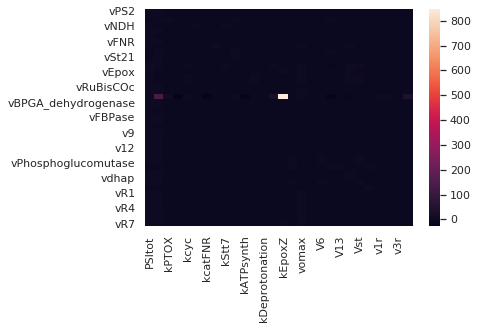

In [492]:
index = m.get_rate_names()
columns = Vmax_list
df = pd.DataFrame(fc_dict_all)

sns.heatmap(df, annot=False)

Due to PGA kinase having such high values that everything else cannot be displayed properly in the heatmap, the PGA kinase is excluded from every further analysis of the metabolic control 

In [537]:
Vmax_list=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1','kATPsynth',
          'kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ',
          'vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx','v1r','v2r','v3r','v4r']

fc_dict_all = {}
cc_dict_all = {}
for vpar in Vmax_list:
    s = Simulator(m)
    rc = response_coefficient(s, vpar)
    fc_dict_all.update({vpar:rc[0]})
    cc_dict_all.update({vpar:rc[1]})

new_fc_all = fc_dict_all
new_cc_all = cc_dict_all

for i in Vmax_list:
    new_fc_all[i].pop('vPGA_kinase')

Figure 17 from the master thesis

Heatmap of all Flux control coefficients (excluding PGA kinase). Due to little space not all
axis labels could be displayed. The red background color indicates small control coefficients close to
zero, while white and black are high positive or high negative values, respectively

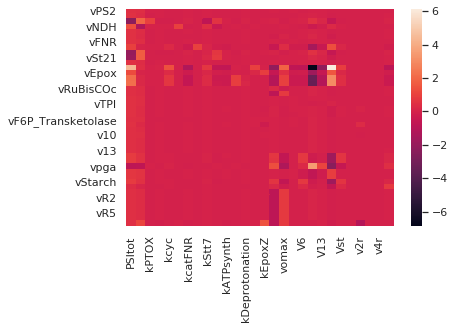

In [224]:
indexrates=[]
for rate in m.get_rate_names():
        if rate != 'vPGA_kinase':
            indexrates.append(rate)
df = pd.DataFrame(new_fc_all)
sns.heatmap(df, annot=False)

Figure 18 from the master thesis

Heatmap of all Concentration control coefficients. Due to little space not all axis labels could
be displayed. The purple background color indicates small control coefficients close to zero, while
white and black are high positive or high negative values, respectively

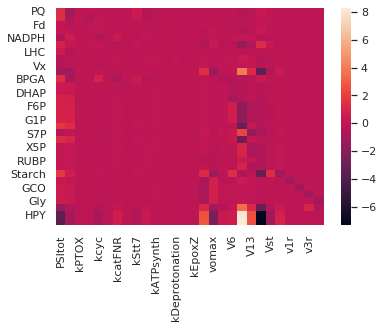

In [538]:
indexrates=[]
#new_cc_all = cc_dict_all
for rate in m.get_rate_names():
        if rate != 'vPGA_kinase':
            indexrates.append(rate)
dfc = pd.DataFrame(new_cc_all)
sns.heatmap(dfc, annot=False)

Additional diagrams showing the influence of oxygen on the flux control coefficients.
As can be seen, high oxygen shfts control to the CBB reactions. (For no oxygen, one extreme value makes analyzing the first diagram useless)

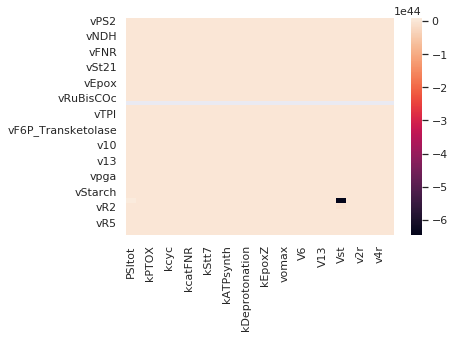

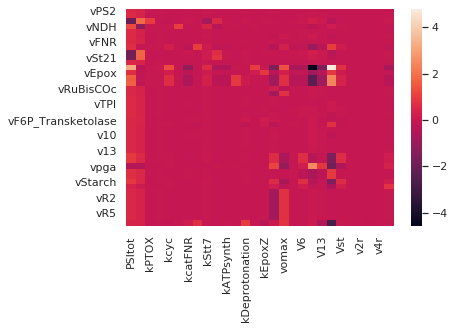

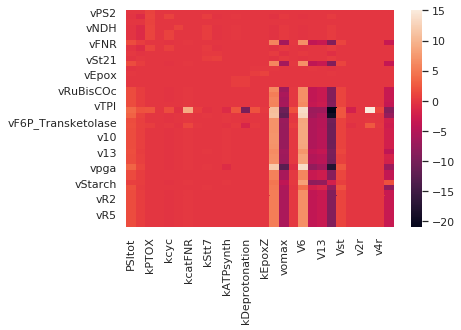

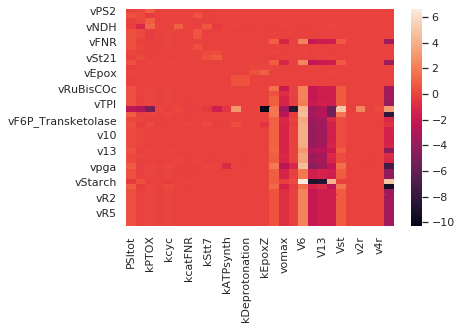

In [238]:
Vmax_list=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1','kATPsynth',
          'kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ',
          'vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx','v1r','v2r','v3r','v4r']

m.update_parameters({'CO2':0.013,'O2':0.27})

fc_dict_all = {}
cc_dict_all = {}
o2values = [0.,0.27,1,2]

for o2 in o2values:
    m.update_parameters({'O2':o2})
    for vpar in Vmax_list:
        s = Simulator(m)
        rc = response_coefficient(s, vpar)
        fc_dict_all.update({vpar:rc[0]})
        cc_dict_all.update({vpar:rc[1]})

    new_fc_all = fc_dict_all
    for i in Vmax_list:
        new_fc_all[i].pop('vPGA_kinase')
    
    df_all = pd.DataFrame(new_fc_all)
    #print('Flux-CCs for ' + str(o2) + ' mM O2')
    plt.figure()
    sns.heatmap(df_all, annot=False)
    
m.update_parameters({'O2': 0.27})

In [252]:
vmax1=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1']
vmax2=['kATPsynth','kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ','v1r','v2r','v3r','v4r']
vmax3=['vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx']

fc_dict_1 = {}
cc_dict_1 = {}
for vpar in vmax1:
    s = Simulator(m)
    rc = response_coefficient(s, vpar)
    fc_dict_1.update({vpar:rc[0]})
    cc_dict_1.update({vpar:rc[1]})

fc_dict_2 = {}
cc_dict_2 = {}
for vpar in vmax2:
    s = Simulator(m)
    rc = response_coefficient(s, vpar)
    fc_dict_2.update({vpar:rc[0]})
    cc_dict_2.update({vpar:rc[1]})

fc_dict_3 = {}
cc_dict_3 = {}
for vpar in vmax3:
    s = Simulator(m)
    rc = response_coefficient(s, vpar)
    fc_dict_3.update({vpar:rc[0]})
    cc_dict_3.update({vpar:rc[1]})

###### smaller heatmaps for better overview of the involved rates/compounds and reactions:

In [253]:
vmax1=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1']
vmax2=['kATPsynth','kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ','v1r','v2r','v3r','v4r']
vmax3=['vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx']

indexrates=[]
for rate in m.get_rate_names():
        if rate != 'vPGA_kinase':
            indexrates.append(rate)

new_fc_1 = fc_dict_1
new_fc_2 = fc_dict_2
new_fc_3 = fc_dict_3

for i in vmax1:
    new_fc_1[i].pop('vPGA_kinase')
columns1 = vmax1
df1f = pd.DataFrame(new_fc_1)

for i in vmax2:
    new_fc_2[i].pop('vPGA_kinase')
columns2 = vmax2
df2f = pd.DataFrame(new_fc_2)

for i in vmax3:
    new_fc_3[i].pop('vPGA_kinase')
columns3 = vmax3
df3f = pd.DataFrame(new_fc_3)

heatmaps of flux control coefficients

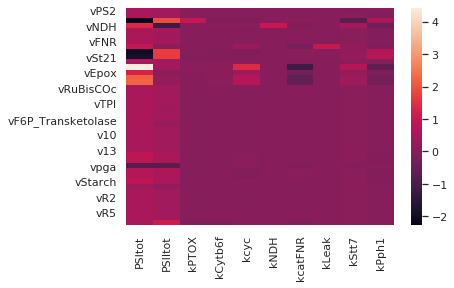

In [254]:
sns.heatmap(df1f, annot=False)

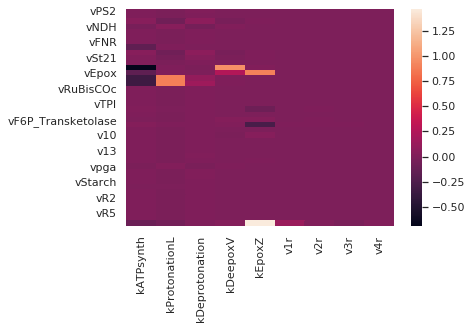

In [255]:
sns.heatmap(df2f, annot=False)

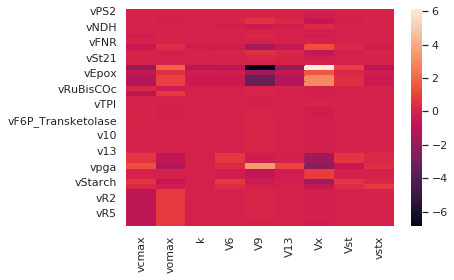

In [256]:
sns.heatmap(df3f, annot=False)

In [257]:
vmax1=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1']
vmax2=['kATPsynth','kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ','v1r','v2r','v3r','v4r']
vmax3=['vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx']

new_cc_1 = cc_dict_1
new_cc_2 = cc_dict_2
new_cc_3 = cc_dict_3

indexrates=[]
for rate in m.get_rate_names():
        if rate != 'vPGA_kinase':
            indexrates.append(rate)

columns1 = vmax1
df1c = pd.DataFrame(new_cc_1)

columns2 = vmax2
df2c = pd.DataFrame(new_cc_2)

columns3 = vmax3
df3c = pd.DataFrame(new_cc_3)

heatmaps of concentration control coefficients

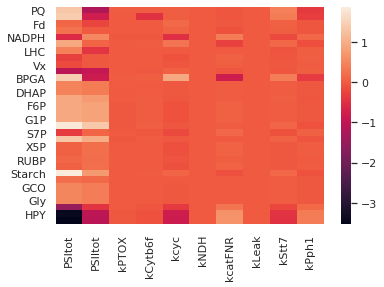

In [258]:
sns.heatmap(df1c, annot=False)

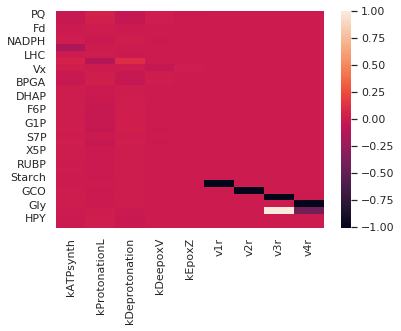

In [259]:
sns.heatmap(df2c, annot=False)

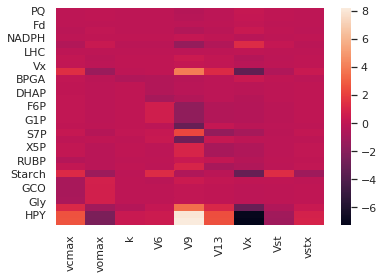

In [260]:
sns.heatmap(df3c, annot=False)

### Tables with all control coefficients (excluding PGA kinase)

In [261]:
# Flux control coefficients part 1
pd.DataFrame(fc_dict_1)

PSItot   PSIItot     kPTOX   kCytb6f      kcyc  \
vPS2                 0.502915  0.442184  0.009624  0.010551 -0.011926   
vPS1                 0.543822  0.400458 -0.008486  0.011568 -0.008988   
vPTOX               -2.277836  1.922414  0.972148 -0.057203 -0.091555   
vNDH                 1.342714 -1.174380  0.016486  0.033873  0.054265   
vB6f                 0.543818  0.400463 -0.008486  0.011568 -0.008988   
vCyc                 0.550490  0.346096 -0.021464  0.011787 -0.004078   
vFNR                 0.541358  0.420525 -0.003692  0.011486 -0.010802   
vLeak                0.974432  0.100492  0.006798  0.021666  0.306734   
vSt12               -1.993580  1.709919 -0.020885 -0.053460 -0.090299   
vSt21               -1.846308  1.692485 -0.037493 -0.033328 -0.034074   
vATPsynthase         0.532724  0.411766 -0.003596  0.011293 -0.009815   
vDeepox              4.418014  0.462837  0.030947  0.098806  1.400361   
vEpox                1.266509  0.084089  0.008354  0.025371  0.348568   
vLhcprotonation      2.186911  0.229236  0.015537  0.049010  0.696191   
vLhcdeprotonation    2.243151  0.216035  0.014453  0.050007  0.690863   
vRuBisCOc            0.510987  0.394051 -0.003442  0.010833 -0.009123   
vRuBisCOo            0.510987  0.394051 -0.003442  0.010833 -0.009123   
vBPGA_dehydrogenase  0.541322  0.420541 -0.003689  0.011483 -0.010797   
vTPI                 0.562869  0.439816 -0.003889  0.011897 -0.012862   
vAldolase            0.539035  0.369440 -0.005811  0.014052 -0.007117   
vFBPase              0.536623  0.410279 -0.003499  0.011434 -0.007255   
vF6P_Transketolase   0.514517  0.422671 -0.015618  0.000938 -0.009844   
v8                   0.520955  0.276093 -0.015939  0.016361 -0.009102   
v9                   0.514058  0.399290 -0.003515  0.010939 -0.009802   
v10                  0.512804  0.413883 -0.001059  0.012150 -0.009797   
v11                  0.514034  0.399252 -0.003511  0.010934 -0.009783   
v12                  0.513997  0.399286 -0.003513  0.010937 -0.009804   
v13                  0.510976  0.394057 -0.003442  0.010833 -0.009126   
vG6P_isomerase       0.838130  0.550088 -0.003707  0.017795  0.027686   
vPhosphoglucomutase  0.855817  0.542741 -0.003460  0.017300  0.032135   
vpga                -0.791430 -0.728929  0.006905 -0.016426  0.060963   
vgap                 0.716083  0.583494 -0.005475  0.014795 -0.030917   
vdhap                0.716083  0.583494 -0.005475  0.014795 -0.030917   
vStarch              0.855507  0.542356 -0.003842  0.017691  0.032345   
vStdeg               0.366189  0.145540 -0.000145  0.005964  0.022742   
vR1                  0.510987  0.394051 -0.003442  0.010833 -0.009123   
vR2                  0.510988  0.394050 -0.003442  0.010833 -0.009122   
vR3                  0.510977  0.394055 -0.003442  0.010833 -0.009125   
vR4                  0.510999  0.394046 -0.003443  0.010833 -0.009120   
vR5                  0.510999  0.394046 -0.003443  0.010833 -0.009120   
vR6                  0.510999  0.394046 -0.003443  0.010833 -0.009120   
vR7                  0.499028  1.088317 -0.068732 -0.104682 -0.000373   

                         kNDH   kcatFNR     kLeak     kStt7     kPph1  
vPS2                -0.000387  0.009891 -0.000070  0.019569 -0.017219  
vPS1                 0.000290  0.007428  0.000069  0.033748 -0.028941  
vPTOX                0.001789  0.076737  0.000411 -0.731731  0.594175  
vNDH                 0.998940 -0.045482 -0.000243  0.433150 -0.355852  
vB6f                 0.000290  0.007429  0.000069  0.033747 -0.028935  
vCyc                 0.000775  0.003317  0.000463  0.043703 -0.037083  
vFNR                 0.000111  0.008947 -0.000076  0.030069 -0.025936  
vLeak               -0.000402 -0.256198  0.999687  0.155367 -0.131729  
vSt12                0.001635  0.075854  0.000372  0.158264  0.692032  
vSt21                0.001202  0.027844  0.000287  0.228497  0.807473  
vATPsynthase         0.000108  0.008122 -0.000076  0.029905 -0.025760  
vDeepox            

In [262]:
# Flux control coefficients part 2
pd.DataFrame(fc_dict_2)

kATPsynth  kProtonationL  kDeprotonation  kDeepoxV  \
vPS2                  0.005453      -0.010674        0.009883 -0.002513   
vPS1                  0.004432      -0.009141        0.008365 -0.001975   
vPTOX                 0.047166      -0.074036        0.071305 -0.024495   
vNDH                 -0.027979       0.043885       -0.042316  0.014520   
vB6f                  0.004432      -0.009141        0.008365 -0.001976   
vCyc                  0.003260      -0.007391        0.006611 -0.001371   
vFNR                  0.004865      -0.009788        0.009013 -0.002199   
vLeak                -0.150884       0.001971       -0.002025  0.001360   
vSt12                 0.046817      -0.070943        0.068907 -0.024669   
vSt21                 0.016494      -0.036213        0.032798 -0.007024   
vATPsynthase          0.004724      -0.009557        0.008776 -0.002121   
vDeepox              -0.689641       0.008733       -0.009238  0.971762   
vEpox                -0.163040       0.004130       -0.002293  0.255027   
vLhcprotonation      -0.342206       0.887700        0.104275  0.003112   
vLhcdeprotonation    -0.337295       0.892406        0.159161  0.002801   
vRuBisCOc             0.004490      -0.009114        0.008363 -0.002009   
vRuBisCOo             0.004490      -0.009114        0.008363 -0.002009   
vBPGA_dehydrogenase   0.004866      -0.009796        0.009013 -0.002196   
vTPI                  0.005110      -0.010259        0.009447 -0.002311   
vAldolase             0.012424      -0.005132        0.008636 -0.000221   
vFBPase               0.004766      -0.009558        0.008823 -0.002163   
vF6P_Transketolase   -0.000704      -0.010337        0.006641  0.034236   
v8                    0.027700       0.004573        0.007883  0.011332   
v9                    0.004577      -0.009273        0.008507 -0.002051   
v10                   0.001445      -0.011137        0.008891 -0.010620   
v11                   0.004577      -0.009277        0.008505 -0.002047   
v12                   0.004582      -0.009280        0.008513 -0.002054   
v13                   0.004491      -0.009115        0.008364 -0.002010   
vG6P_isomerase        0.006426      -0.012112        0.012111 -0.002966   
vPhosphoglucomutase   0.004449      -0.010876        0.008403 -0.000989   
vpga                 -0.011233       0.019409       -0.018834  0.005747   
vgap                  0.006877      -0.013695        0.012616 -0.003122   
vdhap                 0.006877      -0.013695        0.012616 -0.003122   
vStarch               0.004223      -0.010565        0.009117 -0.001476   
vStdeg                0.000263      -0.001302        0.001453 -0.000060   
vR1                   0.004490      -0.009114        0.008363 -0.002009   
vR2                   0.004489      -0.009114        0.008362 -0.002009   
vR3                   0.004491      -0.009116        0.008364 -0.002010   
vR4                   0.004488      -0.009113        0.008361 -0.002008   
vR5                   0.004488      -0.009113        0.008361 -0.002008   
vR6                   0.004488      -0.009113        0.008361 -0.002008   
vR7                  -0.098190      -0.055795        0.005872  0.030835   

                       kEpoxZ           v1r           v2r           v3r  \
vPS2                 0.001011 -9.797278e-08 -2.104392e-08  8.733753e-08   
vPS1                 0.000829 -1.529348e-07 -1.253569e-08  1.578984e-07   
vPTOX                0.008300  8.653300e-06  9.629492e-07 -2.224005e-06   
vNDH                -0.004922 -5.130750e-06 -5.709558e-07  1.318666e-06   
vB6f                 0.000831 -8.286620e-07  9.101703e-08  1.921987e-07   
vCyc                 0.000623 -1.831301e-07  3.459482e-08  3.825293e-07   
vFNR                 0.000908 -2.192148e-07 -6.055631e-08  1.231979e-07   
vLeak               -0.000330 -3.635731e-06 -7.098893e-07  2.164423e-07   
vSt12                0.008179  9.702804e-06  1.070547e-06 -2.625857e-06   
vSt21                0.003137 -1.602439e-06 -

In [263]:
# Flux control coefficients part 3
pd.DataFrame(fc_dict_3)

vcmax     vomax         k        V6        V9  \
vPS2                 0.037010 -0.036097  0.006595 -0.000988  0.036325   
vPS1                 0.000421  0.001629  0.005175  0.009089  0.064202   
vPTOX                0.066585 -0.049361  0.046041  0.083441  0.539365   
vNDH                -0.039480  0.029267 -0.027299 -0.049438 -0.319565   
vB6f                 0.000421  0.001629  0.005175  0.009089  0.064202   
vCyc                -0.097422  0.103171  0.002839  0.039555  0.158759   
vFNR                 0.036568 -0.035884  0.006038 -0.002166  0.029269   
vLeak               -0.457267  0.411280 -0.158924 -0.165961 -1.502943   
vSt12                0.072723 -0.056128  0.044711  0.081298  0.519062   
vSt21               -0.004315  0.012380  0.020111  0.035091  0.252520   
vATPsynthase         0.010351 -0.008602  0.005576  0.006386  0.056840   
vDeepox             -2.084142  1.874073 -0.722599 -0.759243 -6.864235   
vEpox               -0.536867  0.483821 -0.197915 -0.170616 -1.770617   
vLhcprotonation     -1.033421  0.929433 -0.358719 -0.376338 -3.392601   
vLhcdeprotonation   -1.041945  0.937368 -0.365424 -0.364941 -3.431967   
vRuBisCOc            0.228554 -0.225429  0.005249  0.004119  0.110208   
vRuBisCOo           -0.771503  0.774574  0.005249  0.004119  0.110208   
vBPGA_dehydrogenase  0.036571 -0.035886  0.006039 -0.002164  0.029293   
vTPI                 0.037040 -0.039429  0.006967 -0.023207 -0.055376   
vAldolase            0.078566 -0.059981  0.009330  0.051911  0.100111   
vFBPase              0.066424 -0.062113  0.004339  0.051711  0.089412   
vF6P_Transketolase   0.014014 -0.017583  0.006621 -0.001479  0.110755   
v8                   0.052279 -0.011337  0.020415 -0.000742  0.142781   
v9                   0.020220 -0.017197  0.005645 -0.001390  0.114593   
v10                  0.015816 -0.018116  0.002831 -0.001506  0.111160   
v11                  0.020229 -0.017201  0.005647 -0.001418  0.114678   
v12                  0.020235 -0.017209  0.005651 -0.001398  0.114686   
v13                  0.024948 -0.021835  0.005251  0.004123  0.110219   
vG6P_isomerase       0.668123 -0.646866 -0.013088  0.743325 -0.246878   
vPhosphoglucomutase  0.665375 -0.643624 -0.015255  0.741799 -0.262272   
vpga                 1.368497 -1.263636 -0.027804  0.266659  3.496500   
vgap                 0.007453 -0.035004  0.015212 -0.227391 -0.704819   
vdhap                0.007453 -0.035004  0.015212 -0.227391 -0.704819   
vStarch              0.663929 -0.643507 -0.014880  0.740428 -0.261423   
vStdeg               0.249015 -0.241754 -0.013687  0.266790 -0.101904   
vR1                 -0.771503  0.774574  0.005249  0.004119  0.110208   
vR2                 -0.771504  0.774574  0.005249  0.004119  0.110208   
vR3                 -0.771501  0.774571  0.005250  0.004121  0.110219   
vR4                 -0.771507  0.774577  0.005248  0.004117  0.110196   
vR5                 -0.771507  0.774577  0.005248  0.004117  0.110196   
vR6                 -0.771507  0.774577  0.005248  0.004117  0.110196   
vR7                 -0.813162  0.771332 -0.012793  0.001232 -0.014134   

                          V13        Vx       Vst      vstx  
vPS2                 0.010934 -0.023880 -0.007844  0.001917  
vPS1                 0.019998 -0.061304 -0.005682  0.007995  
vPTOX                0.167400 -0.524411 -0.056023  0.066564  
vNDH                -0.099182  0.310706  0.033462 -0.039758  
vB6f                 0.019998 -0.061303 -0.005682  0.007995  
vCyc                 0.050479 -0.181585 -0.001683  0.026877  
vFNR                 0.008737 -0.016866 -0.007162  0.001007  
vLeak               -0.468571  1.350413  0.196300 -0.168667  
vSt12                0.161087 -0.506069 -0.055508  0.064531  
vSt21                0.078722 -0.240255 -0.021555  0.031483  
vATPsynthase         0.017602 -0.051347 -0.006287  0.006373  
vDeepox             -2.136019  6.163762  0.898017 -0.772640  
vEpox               -0.540390  1.548995  0.222243 -0.183322  
vLhcprotonation 

In [264]:
# Concentration control coefficients part 1
pd.DataFrame(cc_dict_1)

PSItot   PSIItot     kPTOX   kCytb6f      kcyc      kNDH   kcatFNR  \
PQ      1.342714 -1.174380  0.016486  0.033873  0.054265 -0.001060 -0.045482   
PC      1.411636 -0.761559  0.009683 -0.465643  0.041284 -0.000749 -0.034655   
Fd      0.123315 -0.237900  0.005879  0.003423  0.164036 -0.000284 -0.007563   
ATP     0.253468  0.011647  0.002181  0.005955  0.091839 -0.000125 -0.076693   
NADPH  -0.575130  0.535159 -0.016096 -0.014617 -0.484129  0.000804  0.404173   
H       0.960116  0.099001  0.006697  0.021345  0.302180 -0.000396 -0.252394   
LHC     0.445051 -0.417407  0.009052  0.008050  0.008233 -0.000290 -0.006728   
Psbs   -0.300490 -0.028225 -0.001884 -0.006518 -0.089992  0.000121  0.074890   
Vx     -0.173940 -0.011389 -0.001130 -0.003433 -0.047153  0.000067  0.038843   
PGA    -1.045259 -0.933573  0.008805 -0.021585  0.071285 -0.000332 -0.059278   
BPGA    1.448285 -0.821683  0.029771  0.035654  0.953497 -0.001529 -0.796120   
GAP     0.462222  0.378834 -0.003575  0.009636 -0.020596  0.000115  0.017134   
DHAP    0.462222  0.378834 -0.003575  0.009636 -0.020596  0.000115  0.017134   
FBP     0.924418  0.757654 -0.007150  0.019272 -0.041191  0.000230  0.034268   
F6P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
G6P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
G1P     0.951138  0.868358 -0.009337  0.019321 -0.090880  0.000322  0.075707   
SBP     1.810908  1.381202 -0.011950  0.037629 -0.030505  0.000355  0.025198   
S7P    -0.332779  0.110869 -0.005499 -0.007707 -0.182539  0.000279  0.152421   
E4P     1.348698  1.002375 -0.008375  0.027993 -0.009909  0.000240  0.008064   
X5P     0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
R5P     0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
RUBP    0.139277  0.204368 -0.002965  0.002718 -0.052196  0.000118  0.043557   
RU5P    0.064711  0.244846 -0.004537  0.000964 -0.101567  0.000197  0.084778   
Starch  1.874234  0.733788 -0.000726  0.029894  0.113966 -0.000107 -0.092346   
PGCO    0.221647  0.164188 -0.001311  0.004964  0.001702  0.000036 -0.001445   
GCO     0.517548  0.399083 -0.003486  0.010971 -0.009239  0.000104  0.007645   
GOX     0.518350  0.399711 -0.003491  0.010988 -0.009255  0.000104  0.007659   
Gly     0.512896  0.395501 -0.003455  0.010873 -0.009154  0.000103  0.007574   
Ser    -1.495663 -0.451185 -0.005270 -0.034197 -0.351830  0.000375  0.293915   
HPY    -3.429599 -1.008216 -0.011939 -0.076541 -0.790546  0.000845  0.660415   
GCA    -3.538422 -1.045416 -0.012161 -0.078826 -0.810965  0.000864  0.677475   

           kLeak     kStt7     kPph1  
PQ     -0.000243  0.433150 -0.355852  
PC     -0.000171  0.382738 -0.311575  
Fd     -0.000109  0.060339 -0.049513  
ATP    -0.000089  0.044478 -0.037952  
NADPH   0.000358 -0.192851  0.157821  
H      -0.000308  0.153066 -0.129775  
LHC    -0.000069 -0.055193  0.046373  
Psbs    0.000094 -0.047397  0.035467  
Vx      0.000052 -0.025973  0.016019  
PGA     0.000108 -0.032019  0.038249  
BPGA   -0.000751  0.398102 -0.327359  
GAP    -0.000058  0.021795 -0.018868  
DHAP   -0.000058  0.021795 -0.018868  
FBP    -0.000117  0.043589 -0.037737  
F6P    -0.000092  0.029298 -0.025404  
G6P    -0.000092  0.029298 -0.025404  
G1P    -0.000092  0.029298 -0.025404  
SBP    -0.000253  0.099971 -0.086341  
S7P     0.000147 -0.075965  0.065268  
E4P    -0.000194  0.078177 -0.067472  
X5P     0.000044 -0.027085  0.023200  
R5P     0.000044 -0.027085  0.023200  
RUBP    0.000007 -0.007527  0.006448  
RU5P    0.000044 -0.027085  0.023200  
Starch -0.000315  0.158151 -0.074536  
PGCO   -0.000036  0.014863 -0.012849  
GCO    -0.000074  0.029247 -0.025042  
GOX    -0.000074  0.029289 -0.025082  
Gly    -0.000073  0.028989 -0.024818  
Ser     0.000418 -0.199764  0.175030  
HPY     0.000939 -0.449574  0.392917  
GCA     0.000966 -0.462161  0.403851

In [265]:
# Concentration control coefficients part 2
pd.DataFrame(cc_dict_2)

kATPsynth  kProtonationL  kDeprotonation  kDeepoxV    kEpoxZ  \
PQ      -0.027979       0.043885       -0.042316  0.014520 -0.004922   
PC      -0.021367       0.032448       -0.031470  0.011260 -0.003734   
Fd      -0.004842       0.007946       -0.007585  0.002463 -0.000859   
ATP     -0.000874       0.001001       -0.000982  0.000492 -0.000136   
NADPH    0.012633      -0.020040        0.019243 -0.006535  0.002225   
H       -0.148649       0.001942       -0.001995  0.001340 -0.000325   
LHC     -0.003982       0.008741       -0.007921  0.001696 -0.000757   
Psbs     0.044181      -0.117346        0.109457 -0.000368  0.000098   
Vx       0.022110      -0.000561        0.000312 -0.034650  0.013364   
PGA     -0.013621       0.024168       -0.023214  0.006830 -0.002546   
BPGA    -0.022070       0.033843       -0.032708  0.011589 -0.003858   
GAP      0.004489      -0.008936        0.008236 -0.002040  0.000832   
DHAP     0.004489      -0.008936        0.008236 -0.002040  0.000832   
FBP      0.008977      -0.017872        0.016472 -0.004079  0.001665   
F6P      0.010537      -0.020877        0.019160 -0.004771  0.001936   
G6P      0.010537      -0.020877        0.019160 -0.004771  0.001936   
G1P      0.010537      -0.020877        0.019160 -0.004771  0.001936   
SBP      0.015664      -0.031713        0.029115 -0.007026  0.002913   
S7P      0.003213      -0.005137        0.004799 -0.001609  0.000544   
E4P      0.011175      -0.022777        0.020879 -0.004986  0.002080   
X5P      0.003851      -0.007036        0.006518 -0.001825  0.000688   
R5P      0.003851      -0.007036        0.006518 -0.001825  0.000688   
RUBP     0.002815      -0.005351        0.004931 -0.001304  0.000509   
RU5P     0.003851      -0.007036        0.006518 -0.001825  0.000688   
Starch   0.001316      -0.006524        0.007282 -0.000303  0.000466   
PGCO     0.001914      -0.003865        0.003568 -0.000867  0.000359   
GCO      0.004547      -0.009230        0.008469 -0.002035  0.000845   
GOX      0.004555      -0.009246        0.008483 -0.002039  0.000847   
Gly      0.004505      -0.009147        0.008392 -0.002016  0.000838   
Ser     -0.002244       0.006279       -0.005944  0.000899 -0.000535   
HPY     -0.004924       0.013888       -0.013154  0.001965 -0.001182   
GCA     -0.005172       0.014493       -0.013720  0.002070 -0.001235   

                 v1r           v2r           v3r       v4r  
PQ     -5.130750e-06 -5.709558e-07  1.318666e-06  0.000025  
PC     -4.740982e-06 -4.359661e-07  1.208102e-06  0.000023  
Fd     -7.668032e-07 -9.385081e-08  1.450865e-07  0.000003  
ATP    -1.056308e-06 -2.030335e-07  5.643324e-08 -0.000001  
NADPH   2.385577e-06  3.050768e-07 -4.831173e-07 -0.000010  
H      -3.581951e-06 -6.993886e-07  2.132407e-07 -0.000004  
LHC     3.868403e-07  3.385533e-08 -2.315385e-07 -0.000006  
Psbs    2.193282e-06  2.614504e-07 -1.130394e-07  0.000004  
Vx      2.672432e-07 -5.550247e-09  3.059178e-07  0.000011  
PGA     7.848745e-06  1.343435e-06  5.969800e-07  0.000034  
BPGA   -2.450124e-06 -6.600722e-07  1.154461e-06  0.000021  
GAP     1.102728e-06 -1.138876e-08  2.189521e-07  0.000003  
DHAP    1.102728e-06 -1.138876e-08  2.189521e-07  0.000003  
FBP     2.205538e-06 -2.312608e-08  4.377582e-07  0.000007  
F6P     2.583363e-06  5.369485e-08  2.148883e-07  0.000008  
G6P     2.583363e-06  5.369485e-08  2.148883e-07  0.000008  
G1P     2.583363e-06  5.369485e-08  2.148884e-07  0.000008  
SBP     1.230733e-06 -2.096078e-07  5.620301e-07  0.000009  
S7P     6.012880e-06  4.907061e-07 -3.764731e-08  0.000007  
E4P     1.284039e-07 -1.976706e-07  3.432134e-07  0.000006  
X5P     3.557789e-06  2.397943e-07  9.066332e-08  0.000005  
R5P     3.557789e-06  2.397943e-07  9.066330e-08  0.000005  
RUBP    1.439158e-06  1.227835e-07  1.005901e-07  0.000004  
RU5P    3.557789e-06  2.397943e-07  9.066331e-08  0.000005  
Starch  5.129491e-06  9.965018e-06  7.653894e-06  0.000316  
PGCO   -1.000446e+00 -1.372672e-05  1.055579e

In [266]:
# Concentration control coefficients part 3
pd.DataFrame(cc_dict_3)

vcmax     vomax         k        V6        V9       V13        Vx  \
PQ     -0.039480  0.029267 -0.027299 -0.049438 -0.319565 -0.099182  0.310706   
PC     -0.033083  0.025496 -0.020433 -0.037177 -0.237714 -0.073705  0.231622   
Fd      0.008980 -0.011454 -0.004671 -0.013790 -0.074100 -0.023190  0.076273   
ATP    -0.134423  0.120904 -0.046823 -0.048582 -0.438601 -0.137126  0.394932   
NADPH  -0.041145  0.048302  0.011667  0.042228  0.211061  0.066204 -0.222379   
H      -0.450503  0.405196 -0.156573 -0.163510 -1.480747 -0.461651  1.330469   
LHC     0.001042 -0.002989 -0.004855 -0.008469 -0.060945 -0.018999  0.057985   
Psbs    0.136923 -0.123181  0.048021  0.048158  0.452884  0.140349 -0.403099   
Vx      0.072812 -0.065618  0.026842  0.023192  0.240686  0.073457 -0.210560   
PGA     1.419238 -1.280018 -0.031849  0.050037  3.987094  1.267621 -3.414875   
BPGA    0.120014 -0.111410 -0.484444 -0.421506 -0.269760 -0.063200  0.418398   
GAP     0.058203 -0.051384  0.011167 -0.444036 -0.213456 -0.051377 -0.160470   
DHAP    0.058203 -0.051384  0.011167 -0.444036 -0.213456 -0.051377 -0.160470   
FBP     0.116404 -0.102767  0.022334 -0.888104 -0.426915 -0.102754 -0.320936   
F6P     0.106410 -0.109535  0.046973  0.728667 -1.657478 -0.464047 -0.366858   
G6P     0.106410 -0.109535  0.046973  0.728667 -1.657478 -0.464047 -0.366858   
G1P     0.106410 -0.109535  0.046973  0.728667 -1.657478 -0.464047 -0.366858   
SBP     0.067474 -0.039892  0.018521 -0.093276 -3.104525  0.210657 -0.161555   
S7P     0.252475 -0.293438  0.090404  0.311876  2.250129 -1.503692 -0.892056   
E4P     0.009272  0.011492  0.007354  0.350739 -2.890876  0.262033 -0.001092   
X5P     0.155340 -0.172411  0.050786 -0.066067  1.018551 -0.777489 -0.526252   
R5P     0.155340 -0.172411  0.050786 -0.066067  1.018551 -0.777489 -0.526252   
RUBP   -0.368142 -0.221305  0.001489 -0.028489  0.428614  0.155451 -0.308677   
RU5P    0.155340 -0.172411  0.050786 -0.066067  1.018551 -0.777489 -0.526252   
Starch  1.247664 -1.211529 -0.068595  1.337494 -0.510864 -0.129764 -3.170110   
PGCO   -0.786159  0.817500  0.000686 -0.149021  0.482493  0.170939  0.037144   
GCO    -0.781317  0.784425  0.005316  0.004171  0.111609  0.034427 -0.072570   
GOX    -0.782531  0.785644  0.005325  0.004180  0.111794  0.034484 -0.072694   
Gly    -0.774345  0.777426  0.005268  0.004132  0.110602  0.034116 -0.071910   
Ser     1.176078 -1.059559 -0.385838  0.223625  3.532671  1.114170 -3.109062   
HPY     2.628775 -2.366077  0.384452  0.508053  8.027072  2.531639 -7.063816   
GCA     2.718167 -2.448644  0.420714  0.521492  8.238189  2.598243 -7.250274   

             Vst      vstx  
PQ      0.033462 -0.039758  
PC      0.025171 -0.029285  
Fd      0.005463 -0.010358  
ATP     0.060742 -0.052233  
NADPH  -0.013512  0.030483  
H       0.193363 -0.166144  
LHC     0.005217 -0.007620  
Psbs   -0.057478  0.048882  
Vx     -0.029706  0.024503  
PGA    -0.526614  0.429027  
BPGA    0.043199 -0.060962  
GAP    -0.007849  0.010022  
DHAP   -0.007849  0.010022  
FBP    -0.015699  0.020044  
F6P    -0.136829  0.029781  
G6P    -0.136829  0.029781  
G1P    -0.136829  0.029781  
SBP    -0.076767 -0.024736  
S7P    -0.143671  0.139100  
E4P    -0.068918 -0.034758  
X5P    -0.075760  0.074561  
R5P    -0.075760  0.074561  
RUBP   -0.048187  0.041329  
RU5P   -0.075760  0.074561  
Starch  1.390416 -1.167688  
PGCO    0.016353  0.001343  
GCO    -0.020130  0.011147  
GOX    -0.020163  0.011165  
Gly    -0.019949  0.011046  
Ser    -0.489530  0.410316  
HPY    -1.070342  0.896990  
GCA    -1.096431  0.918994

defining function for supply-demand diagrams (all fluxes included)

In [300]:
import pickle
CBBlist=np.linspace(1.,3,3)
PFDlist=np.linspace(50.,500,10)
o2list=np.linspace(0.,0.4,5)

Vmax_list=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1','kATPsynth',
          'kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ',
          'vcmax','vomax','k','V6','V9','V13','Vx','Vst','vstx','v1r','v2r','v3r','v4r']

demand_pars=['vcmax', 'vomax' ,'V6' ,'V9', 'V13','Vst','vstx', 'Vx', 'v1r','v2r','v3r','v4r'] 

def FluxControlCoefficients(pfdlist, cbblist):
    """ calculate all flux control coefficients 
        using response_coefficients function"""

    for CBB in cbblist:
        for pfd in pfdlist:

            FluxControlCoefficients= {}
            ConcentrationControlCoefficients= {}
            cnt=0
            for vmax in Vmax_list:
                cnt+=1
                print(str(cnt)+' of '+str(vmax))
                
                RC=response_coefficient(s, vmax,CBBspeed=CBB,lightintensity=pfd)
                
                FluxControlCoefficients.update({vmax:RC[0]})
                ConcentrationControlCoefficients.update({vmax:RC[1]})

            pickle.dump(FluxControlCoefficients, open( "flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "wb" ) )
        

def SupplyDemand(pfdlist, cbblist, option='file'):
    """ calculate the cumulative supply-demand coefficient """
    if option=='file':
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for pfd in pfdlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "//home/eldin/env/photosynthesismodel-2019-modelbase1.0/supp dem Photoresp5/flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))

                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    elif option=='calculate':
        FluxControlCoefficients(pfdlist, cbblist)
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for pfd in PFDlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))


                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    DemandSupply=np.array(DemandSupply)
    fig, axis = plt.subplots() 
    plt.rcParams["figure.figsize"] = (10, 3)
    heatmap = axis.pcolor(DemandSupply, cmap=plt.cm.RdYlBu_r)

    axis.set_yticks(np.arange(DemandSupply.shape[0])+0.5, minor=False)
    axis.set_xticks(np.arange(DemandSupply.shape[1])+0.5, minor=False)

    axis.set_yticklabels(cbblist, minor=False)
    axis.set_xticklabels(PFDlist, minor=False)

    axis.set_xlabel('Light',fontsize=20.)
    axis.set_ylabel(r'$f_\mathrm{CBB}$',fontsize=20.)

    axis.tick_params(labelsize=15)
    axis.text(0.6,2.6,r'$C_{Supply} > C_{Demand}$',fontsize=12.,color='w')
    axis.text(8.1,0.35,r'$C_{Demand} > C_{Supply}$',fontsize=12.,color='w')

    plt.xticks(rotation=90)

    cb=fig.colorbar(heatmap)
    #cb.ax.set_yticklabels( fontsize=18)

    plt.tight_layout() 


def SupplyDemand2(pfdlist, o2list, option='file'):
    """ calculate the cumulative supply-demand coefficient """
    if option=='file':
        DemandSupply=[]
        for o2 in o2list:
            print(o2)


            DemSup=[]
            for pfd in pfdlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "//home/eldin/env/photosynthesismodel-2019-modelbase1.0/supp dem Photoresp5/flux-pfd"+str(int(pfd))+"O2-"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))

                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    elif option=='calculate':
        FluxControlCoefficients(pfdlist, o2list)
        DemandSupply=[]
        for o2 in o2list:
            print(o2)


            DemSup=[]
            for pfd in PFDlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "flux-pfd"+str(int(pfd))+"O2-"+str(int(o2))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))


                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    DemandSupply=np.array(DemandSupply)
    fig, axis = plt.subplots() 
    plt.rcParams["figure.figsize"] = (10, 3)
    heatmap = axis.pcolor(DemandSupply, cmap=plt.cm.RdYlBu_r)

    axis.set_yticks(np.arange(DemandSupply.shape[0])+0.5, minor=False)
    axis.set_xticks(np.arange(DemandSupply.shape[1])+0.5, minor=False)

    axis.set_yticklabels(cbblist, minor=False)
    axis.set_xticklabels(PFDlist, minor=False)

    axis.set_xlabel('Light',fontsize=20.)
    axis.set_ylabel('O$_{2}$ [mM]',fontsize=20.)

    axis.tick_params(labelsize=15)
    axis.text(0.6,2.6,r'$C_{Supply} > C_{Demand}$',fontsize=12.,color='w')
    axis.text(8.1,0.35,r'$C_{Demand} > C_{Supply}$',fontsize=12.,color='w')

    plt.xticks(rotation=90)

    cb=fig.colorbar(heatmap)
    #cb.ax.set_yticklabels( fontsize=18)

    plt.tight_layout() 

defining functions for response coefficients and supply-demand diagrams excluding the PGAkinase

In [338]:
def response_coefficientX(s, par, CBBspeed=1.,lightintensity=100.,kcyc=1., var=0.01):   
    s.update_parameters({'vcmax':2.913930914*8*CBBspeed, 'vomax':0.475*8*CBBspeed, 
                         'V6' : 0.2*8*CBBspeed, 'V9' : 0.04*8*CBBspeed, 'V13' : 0.9999*8*CBBspeed, 
                         'Vst' : 0.04*8*CBBspeed,'kcyc' : kcyc,
                         'v1r':52.4199*8*CBBspeed, 'v2r':1.45611*8*CBBspeed, 'v3r':2.74582*8*CBBspeed,
                         'v4r':2.49475*8*CBBspeed, 'pfd':lightintensity})
    
    Y={}
    X={}
    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    
    for rate in m.get_rate_names():
        X.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y.update({compd:s.get_results_dict()[compd][-1]})
    
    Y1={}
    X1={}
    xvar=m.get_parameter(par)
    s.update_parameters({par:xvar*(1+var)})
    
    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X1.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y1.update({compd:s.get_results_dict()[compd][-1]})

    Y99={}
    X99={}
    s.update_parameters({par:xvar*(1-var)})

    s.initialise(y0)
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X99.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y99.update({compd:s.get_results_dict()[compd][-1]})
    flux_coefficient_dict={}
    concentration_coefficient_dict={}
    
    for name in m.get_rate_names():
        fluxcoefficient= ( ( ( X1[name] - X99[name] ) / X[name] ) )/ (var*2)
        flux_coefficient_dict.update({name:fluxcoefficient})
    flux_coefficient_dict.pop('vPGA_kinase')
    for name in m.get_compounds():
        conc_coefficient= ( ( ( Y1[name] - Y99[name] ) / Y[name] ) )/ (var*2)
        concentration_coefficient_dict.update({name:conc_coefficient})
    return [flux_coefficient_dict, concentration_coefficient_dict]

########################################################

def response_coefficientX2(s, par, CBBspeed=1., oxygen=0.27, kcyc=1., var=0.01):   
    s.update_parameters({'vcmax':2.913930914*8*CBBspeed, 'vomax':0.475*8*CBBspeed, 
                         'V6' : 0.2*8*CBBspeed, 'V9' : 0.04*8*CBBspeed, 'V13' : 0.9999*8*CBBspeed, 
                         'Vst' : 0.04*8*CBBspeed,'kcyc' : kcyc,
                         'v1r':52.4199*8*CBBspeed, 'v2r':1.45611*8*CBBspeed, 'v3r':2.74582*8*CBBspeed,
                         'v4r':2.49475*8*CBBspeed, 'O2':oxygen})
    
    Y={}
    X={}
    s.initialise(y0)
    s.simulate(50, steps=50, **{'atol': 1.e-14})
    s.simulate(100, steps=100, **{'atol': 1.e-14})
    s.simulate(126, steps=126, **{'atol': 1.e-14})
    s.simulate(150, steps=150, **{'atol': 1.e-14})
    s.simulate(200, steps=200, **{'atol': 1.e-14})
    s.simulate(250, steps=250, **{'atol': 1.e-14})
    s.simulate(300, steps=300, **{'atol': 1.e-14})
    s.simulate(350, steps=350, **{'atol': 1.e-14})
    s.simulate(400, steps=400, **{'atol': 1.e-14})
    s.simulate(450, steps=450, **{'atol': 1.e-14})
    s.simulate(460, steps=460, **{'atol': 1.e-14})
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    
    for rate in m.get_rate_names():
        X.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y.update({compd:s.get_results_dict()[compd][-1]})
    
    Y1={}
    X1={}
    xvar=m.get_parameter(par)
    s.update_parameters({par:xvar*(1+var)})
    
    s.initialise(y0)
    s.simulate(50, steps=50, **{'atol': 1.e-14})
    s.simulate(100, steps=100, **{'atol': 1.e-14})
    s.simulate(126, steps=126, **{'atol': 1.e-14})
    s.simulate(150, steps=150, **{'atol': 1.e-14})
    s.simulate(200, steps=200, **{'atol': 1.e-14})
    s.simulate(250, steps=250, **{'atol': 1.e-14})
    s.simulate(300, steps=300, **{'atol': 1.e-14})
    s.simulate(350, steps=350, **{'atol': 1.e-14})
    s.simulate(400, steps=400, **{'atol': 1.e-14})
    s.simulate(450, steps=450, **{'atol': 1.e-14})
    s.simulate(460, steps=460, **{'atol': 1.e-14})
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X1.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y1.update({compd:s.get_results_dict()[compd][-1]})

    Y99={}
    X99={}
    s.update_parameters({par:xvar*(1-var)})

    s.initialise(y0)
    s.simulate(50, steps=50, **{'atol': 1.e-14})
    s.simulate(100, steps=100, **{'atol': 1.e-14})
    s.simulate(126, steps=126, **{'atol': 1.e-14})
    s.simulate(150, steps=150, **{'atol': 1.e-14})
    s.simulate(200, steps=200, **{'atol': 1.e-14})
    s.simulate(250, steps=250, **{'atol': 1.e-14})
    s.simulate(300, steps=300, **{'atol': 1.e-14})
    s.simulate(350, steps=350, **{'atol': 1.e-14})
    s.simulate(400, steps=400, **{'atol': 1.e-14})
    s.simulate(450, steps=450, **{'atol': 1.e-14})
    s.simulate(460, steps=460, **{'atol': 1.e-14})
    s.simulate(500, steps=500, **{'atol': 1.e-14})
    for rate in m.get_rate_names():
        X99.update({rate:s.get_fluxes_dict()[rate][-1]})
    for compd in m.get_compounds():
        Y99.update({compd:s.get_results_dict()[compd][-1]})
    flux_coefficient_dict={}
    concentration_coefficient_dict={}
    
    for name in m.get_rate_names():
        fluxcoefficient= ( ( ( X1[name] - X99[name] ) / X[name] ) )/ (var*2)
        flux_coefficient_dict.update({name:fluxcoefficient})
    flux_coefficient_dict.pop('vPGA_kinase')
    for name in m.get_compounds():
        conc_coefficient= ( ( ( Y1[name] - Y99[name] ) / Y[name] ) )/ (var*2)
        concentration_coefficient_dict.update({name:conc_coefficient})
    return [flux_coefficient_dict, concentration_coefficient_dict]

In [339]:
import pickle
CBBlist=np.linspace(1.,3,3)
PFDlist=np.linspace(50.,500,10)
O2list=np.linspace(0.1,1,10)

Vmax_list=['PSItot','PSIItot','kPTOX','kCytb6f','kcyc','kNDH','kcatFNR','kLeak','kStt7','kPph1','kATPsynth',
          'kProtonationL','kDeprotonation','kDeepoxV','kEpoxZ',
          'vcmax','vomax','k','V6','V9','V13','Vx','Vst','v1r','v2r','v3r','v4r','vstx']

demand_pars=['vcmax', 'vomax' ,'V6' ,'V9', 'V13','Vst', 'vstx', 'Vx', 'v1r','v2r','v3r','v4r'] 

def FluxControlCoefficientsX(pfdlist, cbblist):
    """ calculate all flux control coefficients 
        using response_coefficients function"""

    for CBB in cbblist:
        for pfd in pfdlist:

            FluxControlCoefficients= {}
            ConcentrationControlCoefficients= {}
            cnt=0
            for vmax in Vmax_list:
                cnt+=1
                print(str(cnt)+' of '+str(vmax))
                
                RC=response_coefficientX(s, vmax,CBBspeed=CBB,lightintensity=pfd)
                
                FluxControlCoefficients.update({vmax:RC[0]})
                ConcentrationControlCoefficients.update({vmax:RC[1]})

            pickle.dump(FluxControlCoefficients, open( "X-flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "wb" ) )
        
def FluxControlCoefficientsX2(o2list, cbblist):
    """ calculate all flux control coefficients 
        using response_coefficients function"""

    for CBB in cbblist:
        for o2 in o2list:

            FluxControlCoefficients= {}
            ConcentrationControlCoefficients= {}
            cnt=0
            for vmax in Vmax_list:
                cnt+=1
                print(str(cnt)+' of '+str(vmax))
                
                RC=response_coefficientX2(s, vmax,CBBspeed=CBB,oxygen=o2)
                
                FluxControlCoefficients.update({vmax:RC[0]})
                ConcentrationControlCoefficients.update({vmax:RC[1]})

            pickle.dump(FluxControlCoefficients, open( "X2-flux-O2-"+str(int(o2))+"cbb"+str(int(CBB))+".p", "wb" ) )
   
        
def SupplyDemandX(pfdlist, cbblist, option='file'):
    """ calculate the cumulative supply-demand coefficient """
    if option=='file':
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for pfd in pfdlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "//home/eldin/env/photosynthesismodel-2019-modelbase1.0/photoresp6/X-flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))

                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    elif option=='calculate':
        FluxControlCoefficientsX(pfdlist, cbblist)
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for pfd in PFDlist:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "X-flux-pfd"+str(int(pfd))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))


                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    DemandSupply=np.array(DemandSupply)
    fig, axis = plt.subplots() 
    plt.rcParams["figure.figsize"] = (10, 3)
    heatmap = axis.pcolor(DemandSupply, cmap=plt.cm.RdYlBu_r)

    axis.set_yticks(np.arange(DemandSupply.shape[0])+0.5, minor=False)
    axis.set_xticks(np.arange(DemandSupply.shape[1])+0.5, minor=False)

    axis.set_yticklabels(cbblist, minor=False)
    axis.set_xticklabels(PFDlist, minor=False)

    axis.set_xlabel('Light',fontsize=20.)
    axis.set_ylabel(r'$f_\mathrm{CBB}$',fontsize=20.)

    axis.tick_params(labelsize=15)
    axis.text(0.6,2.6,r'$C_{Supply} > C_{Demand}$',fontsize=12.,color='w')
    axis.text(8.1,0.35,r'$C_{Demand} > C_{Supply}$',fontsize=12.,color='w')

    plt.xticks(rotation=90)

    cb=fig.colorbar(heatmap)
    #cb.ax.set_yticklabels( fontsize=18)

    plt.tight_layout() 


def SupplyDemandX2(o2list, cbblist, option='file'):
    """ calculate the cumulative supply-demand coefficient """
    if option=='file':
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for o2 in o2list:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "//home/eldin/env/photosynthesismodel-2019-modelbase1.0/photoresp6/X2-flux-O2-"+str(int(o2))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))

                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    elif option=='calculate':
        FluxControlCoefficientsX2(o2list, cbblist)
        DemandSupply=[]
        for CBB in cbblist:
            print(CBB)


            DemSup=[]
            for o2 in o2list:

                d1=[]
                s1=[]
                FCC = pickle.load( open( "X2-flux-O2-"+str(int(o2))+"cbb"+str(int(CBB))+".p", "rb" ) )
                for rate in FCC['V9']:
                    for par in Vmax_list:
                        if par in demand_pars:
                            d1.append(abs(FCC[par][rate]))
                        else:
                            s1.append(abs(FCC[par][rate]))


                DemSup.append(sum(d1)/(sum(d1)+sum(s1)))

            DemandSupply.append(DemSup)

    DemandSupply=np.array(DemandSupply)
    fig, axis = plt.subplots() 
    plt.rcParams["figure.figsize"] = (10, 3)
    heatmap = axis.pcolor(DemandSupply, cmap=plt.cm.RdYlBu_r)

    axis.set_yticks(np.arange(DemandSupply.shape[0])+0.5, minor=False)
    axis.set_xticks(np.arange(DemandSupply.shape[1])+0.5, minor=False)

    axis.set_yticklabels(cbblist, minor=False)
    axis.set_xticklabels(o2list, minor=False)

    axis.set_xlabel('Oxygen [mM]',fontsize=20.)
    axis.set_ylabel(r'$f_\mathrm{CBB}$',fontsize=20.)

    axis.tick_params(labelsize=15)
    axis.text(0.6,2.6,r'$C_{Supply} > C_{Demand}$',fontsize=12.,color='w')
    axis.text(8.1,0.35,r'$C_{Demand} > C_{Supply}$',fontsize=12.,color='w')

    plt.xticks(rotation=90)

    cb=fig.colorbar(heatmap)
    #cb.ax.set_yticklabels( fontsize=18)

    plt.tight_layout() 

Figure 19 from the masther thesis: 

Comparison of total control by energy demanding reactions (C demand ) and energy supplying
reactions (C supply ), under varying light intensities and Calvin cycle velocity (f CBB ). Red color means
control is on the demand side, blue color means control is on the supply side

1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of v5r
29 of v6r
30 of v7r
1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of v5r
29 of v6r
30 of v7r
1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r


13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of v5r
29 of v6r
30 of v7r
1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of v5r
29 of v6r
30 of v7r
1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of v5r
29 of v6r
30 of v7r
1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt

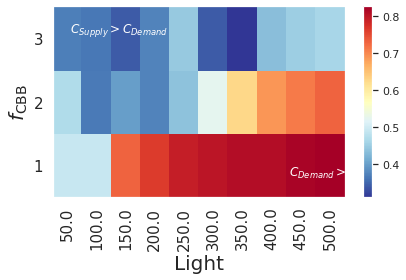

In [16]:
# removed PGAkinase
SupplyDemandX(pfdlist=PFDlist, cbblist=[1,2,3], option='calculate')

1
2
3


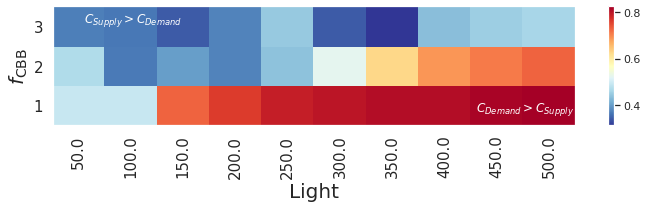

In [18]:
# removed PGAkinase
SupplyDemandX(pfdlist=PFDlist, cbblist=[1,2,3], option='file')

Figure 20 from the masther thesis: 

Comparison of total control by energy demanding reactions (C demand ) and energy supplying
reactions (C supply ), under varying oxygen concentrations (mM) and Calvin cycle velocity (f CBB ). Red
color means control is on the demand side, blue color means control is on the supply side

In [336]:
# removed PGA kinase
SupplyDemandX2(o2list=O2list, cbblist=CBBlist, option='calculate')

1 of PSItot
2 of PSIItot
3 of kPTOX
4 of kCytb6f
5 of kcyc
6 of kNDH
7 of kcatFNR
8 of kLeak
9 of kStt7
10 of kPph1
11 of kATPsynth
12 of kProtonationL
13 of kDeprotonation
14 of kDeepoxV
15 of kEpoxZ
16 of vcmax
17 of vomax
18 of k
19 of V6
20 of V9
21 of V13
22 of Vx
23 of Vst
24 of v1r
25 of v2r
26 of v3r
27 of v4r
28 of vstx


FileNotFoundError: [Errno 2] No such file or directory: 'X2-flux-pfd-50o2-0.p'

1.0
2.0
3.0


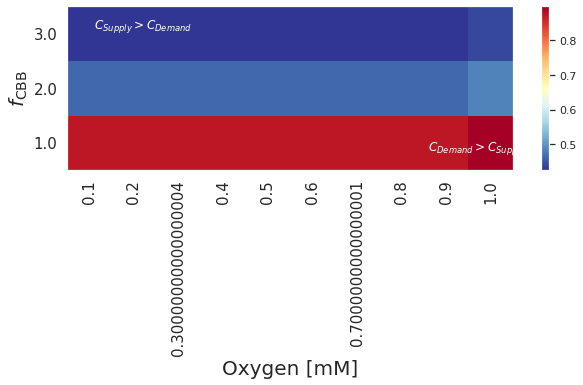

In [332]:
#result with kcyc=3
# removed PGA kinase
SupplyDemandX2(o2list=O2list, cbblist=CBBlist, option='file')